Reading data...
Successfully loaded data with 287829 rows and 48 columns
Dropping variables with many NAs...
Filtering data for years 2010-2015...
Years in data:
year
2010    26784
2011    28222
2012    28469
2013    28474
2014    28151
2015    27506
Name: count, dtype: int64
Adding missing year-company combinations...
Generating status_alive...
Creating sales metrics...
Calculating sales growth...
Creating age variable...
Creating fast growth target with new definition...
Number of firms with data in both 2012 and 2014: 17927
Number of fast-growing firms: 3885.0
Percentage of fast-growing firms: 22.60%

Breakdown of criteria for fast-growing firms:
Employee growth condition met: 7.13%
Profit growth condition met: 80.98%
Fixed assets growth condition met: 44.63%


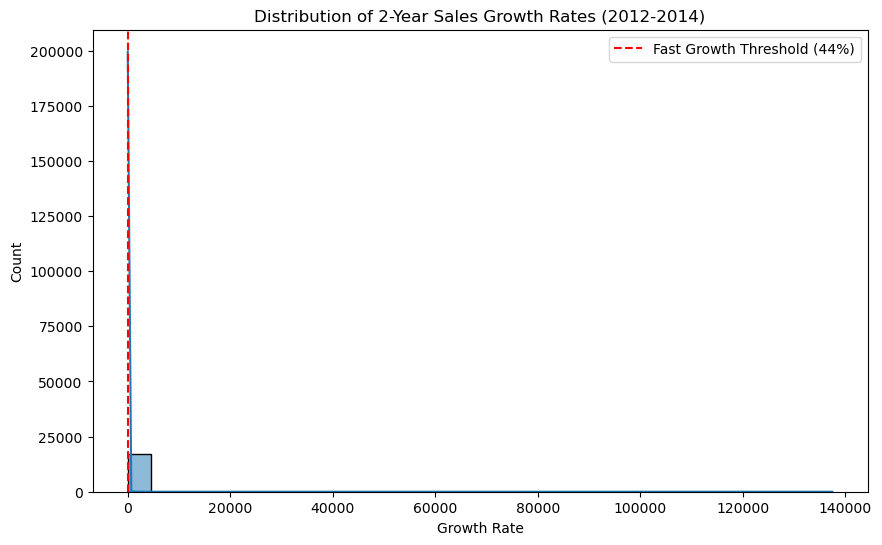

Created visualization of growth distribution


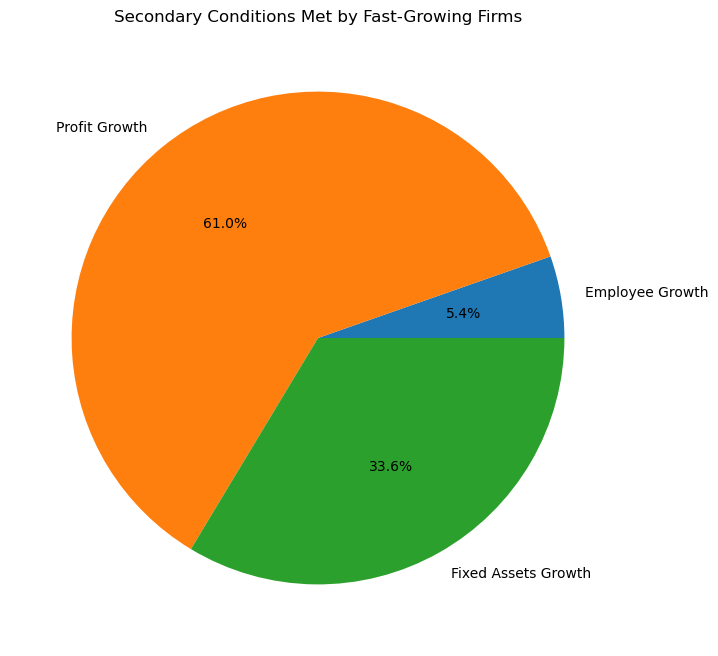

Created visualization of secondary conditions met
Creating sample for modeling...
Final sample size: 21723 firms
Feature engineering...
Industry distribution:
industry_group
Services         15372
Manufacturing     6351
Name: count, dtype: int64

# Exploratory Analysis for Fast Growth Prediction
## Running OLS regressions to understand relationships between variables

OLS Regression: Effect of Firm Size on Fast Growth
                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     160.6
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           8.15e-70
Time:                        16:43:09   Log-Likelihood:                -8777.3
No. Observations:               16619   AIC:                         1.756e+04
Df Residuals:            

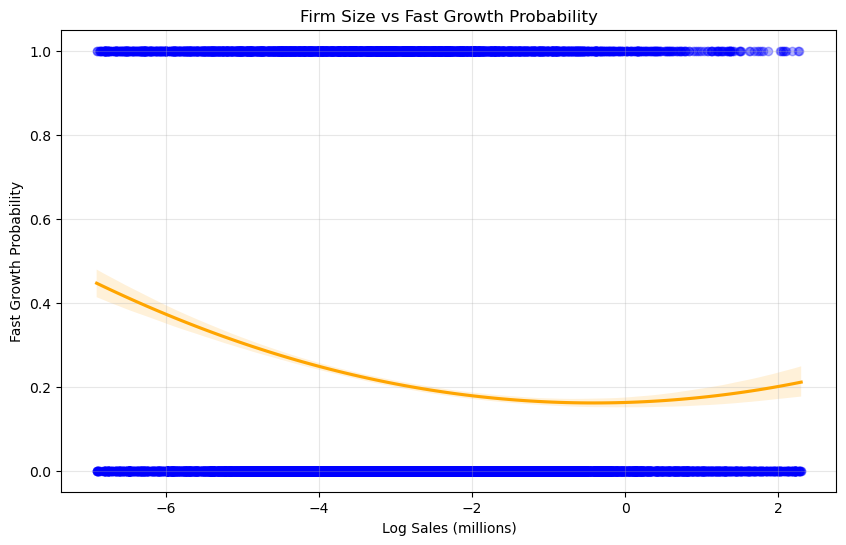


Created visualization of firm size vs fast growth


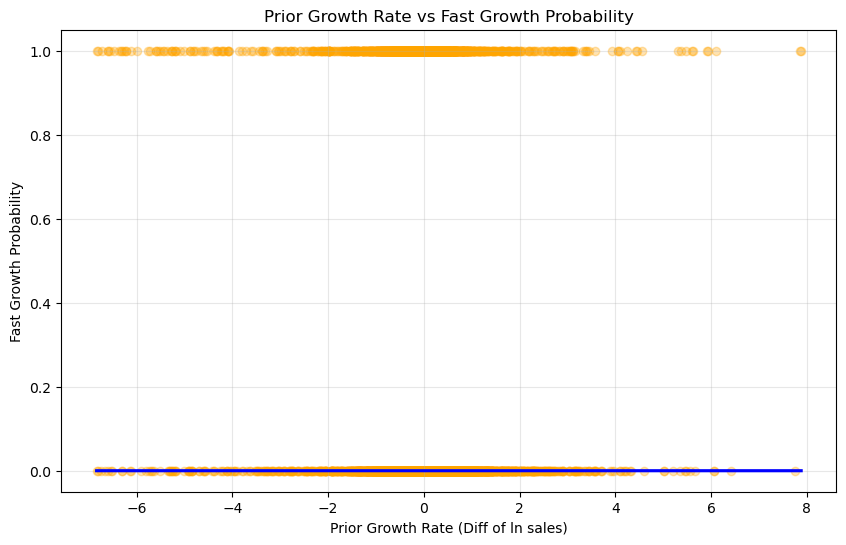

Created visualization of prior growth vs fast growth


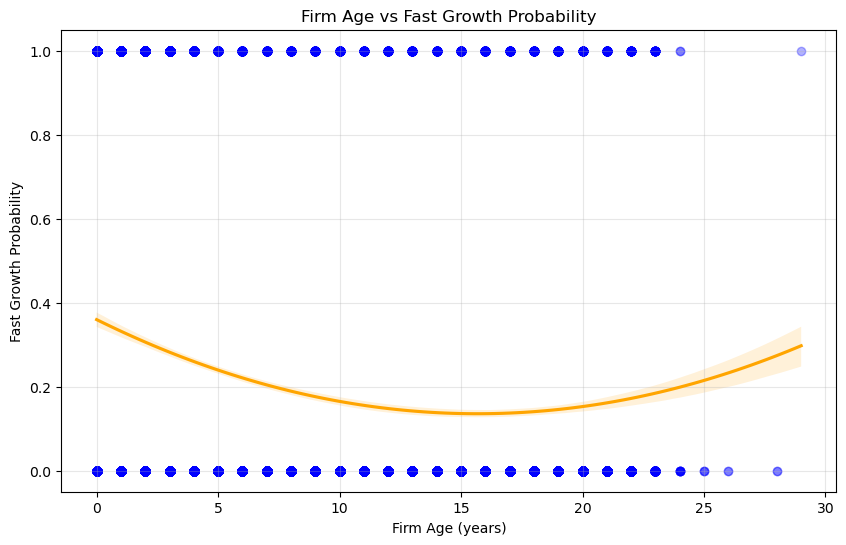

Created visualization of firm age vs fast growth


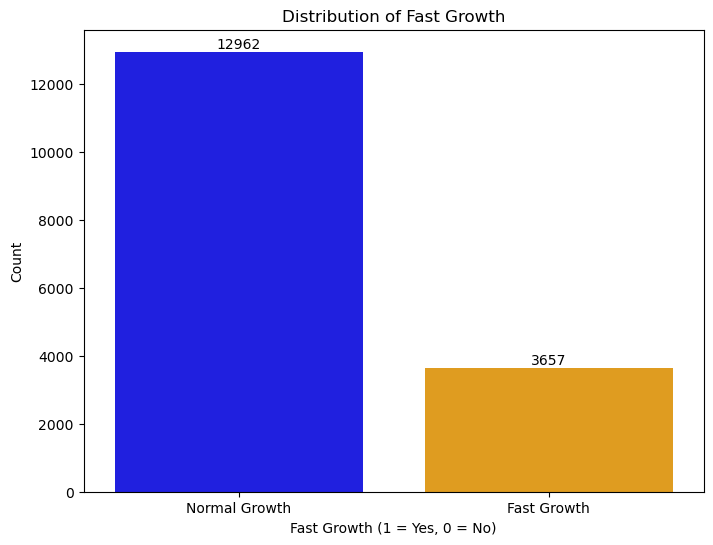

Created fast growth distribution bar chart


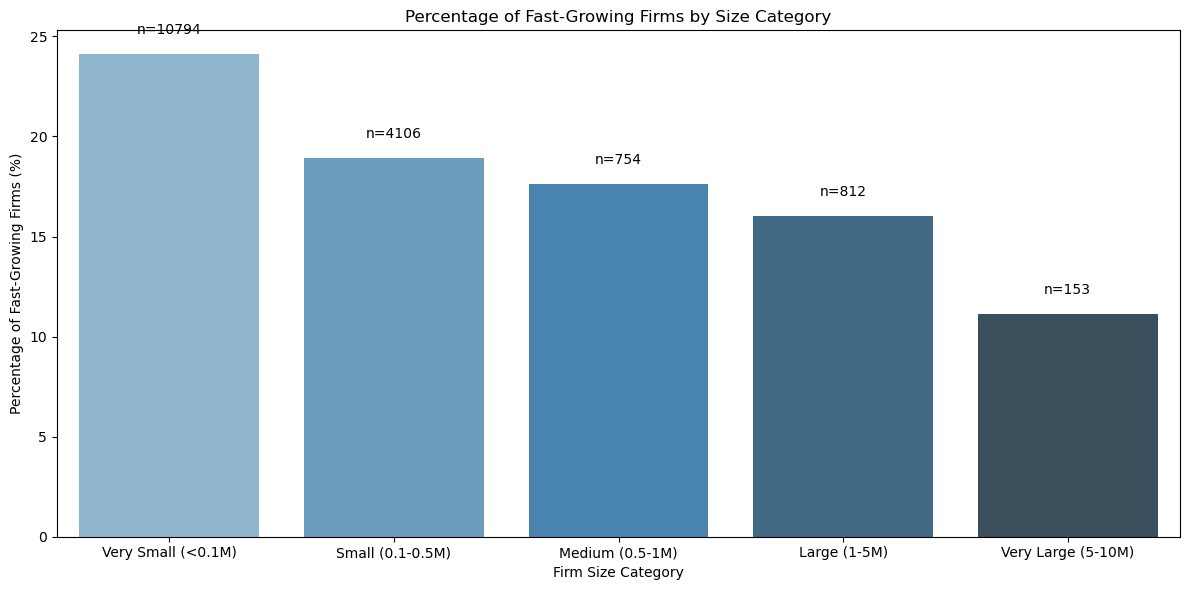

Created firm size analysis plot


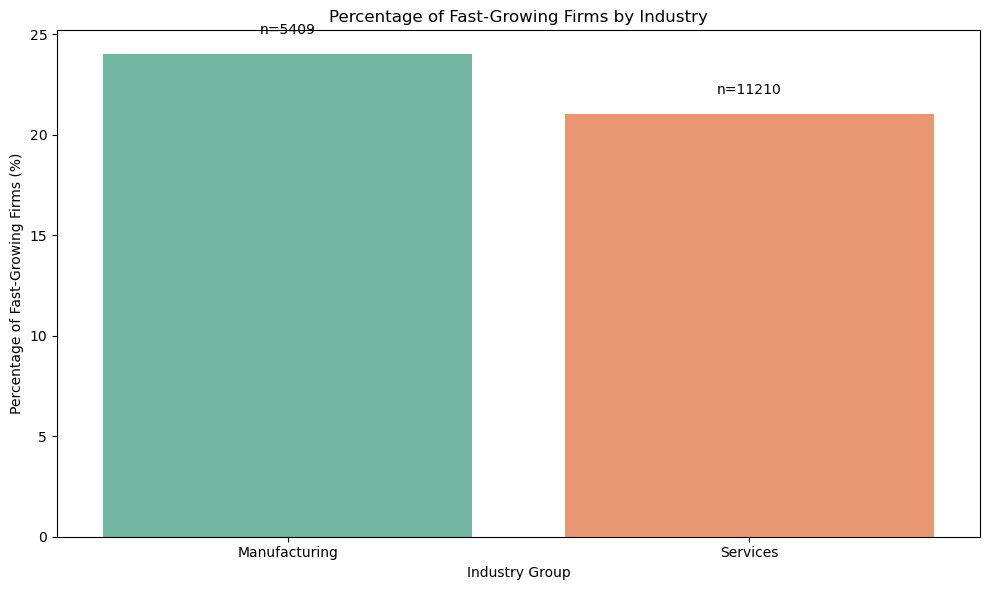

Created industry analysis plot
Saving prepared data to ./fast_growth_firms_clean.csv

Fast Growth Distribution:
   fast_growth  comp_id  percentage
0          0.0    12962   77.995066
1          1.0     3657   22.004934

Detailed analysis of growth criteria:
Sales growth ≥44%: 29.71%
Employee growth ≥21% with personnel costs ≤32%: 6.79%
Profit growth ≥32% or turned positive: 42.52%
Fixed assets growth ≥21%: 25.63%

Finished data preparation. Ready for modeling!


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Set up paths
data_dir = "."  # Change this to your data directory
output_dir = "."  # Change this to your output directory

# Load the prepared data
print("Loading prepared data...")
data_path = os.path.join(data_dir, "fast_growth_firms_clean.csv")
try:
    data = pd.read_csv(data_path)
    print(f"Loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    raise

# Print basic statistics about the target variable
print("\nTarget variable distribution:")
print(data["fast_growth"].value_counts())
print(f"Proportion fast growth: {data['fast_growth'].mean():.4f}")

# Define features for model building
# Basic numerical features
numerical_features = [
    "sales_mil_log", "sales_mil_log_sq",
    "age", "age2", 
    "growth_1y", "growth_1y_sq",
    "ceo_age",
    "foreign"
]

# Categorical features to one-hot encode
categorical_features = [
    "ind2_cat", "urban_m", "gender_m", "m_region_loc",
]

# Binary flags
binary_features = [
    "new", "ceo_young", "foreign_management"
]

# Make sure we have no NaN values in the target variable
print("Checking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data['fast_growth'].isna().sum()}")

# Drop rows with NaN in the target variable
data_model = data.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN targets: {data_model.shape}")

# Split into X (features) and y (target)
X = data_model[numerical_features + categorical_features + binary_features]
y = data_model["fast_growth"].astype(int)  # Ensure target is integer type

# Create dummy variables for categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Check for any remaining NaN values in features
print("Checking for NaN values in features...")
nan_counts = X.isna().sum()
print(f"Columns with NaN values: {nan_counts[nan_counts > 0]}")

# Fill any remaining NaN values with column means for numeric features
X = X.fillna(X.mean())
print("Filled any remaining NaN values in features")

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create a visualization of the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fast_growth', data=data_model)
# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)
plt.title('Fast Growth Distribution')
plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
plt.savefig('fast_growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
print("Created visualization of class distribution")

# Create a function to evaluate models
def evaluate_model(model, X, y, cv=5, scoring=None, model_name="Model"):
    """
    Evaluate a model using cross-validation and return metrics.
    """
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    # Cross-validation scores
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Print mean and standard deviation of each metric
    print(f"\n{model_name} - Cross-Validation Results (Mean ± Std):")
    for metric in scoring:
        score_key = f'test_{metric}'
        if score_key in cv_results:
            mean_score = cv_results[score_key].mean()
            std_score = cv_results[score_key].std()
            print(f"{metric.capitalize():10}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_results

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", figsize=(8, 6), save_path=None):
    """
    Plot a confusion matrix for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal Growth', 'Fast Growth'],
                yticklabels=['Normal Growth', 'Fast Growth'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    return cm

def calculate_expected_loss(y_true, y_pred, fp_cost=1, fn_cost=5):
    """
    Calculate expected loss based on false positive and false negative costs.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_fp_cost = fp * fp_cost
    total_fn_cost = fn * fn_cost
    total_cost = total_fp_cost + total_fn_cost
    
    print(f"False Positives: {fp} x ${fp_cost} = ${total_fp_cost}")
    print(f"False Negatives: {fn} x ${fn_cost} = ${total_fn_cost}")
    print(f"Total Cost: ${total_cost}")
    
    return total_cost, total_fp_cost, total_fn_cost

def find_optimal_threshold(model, X, y, fp_cost=1, fn_cost=5, n_thresholds=100):
    """
    Find the optimal threshold for classification based on the specified cost function.
    """
    y_proba = model.predict_proba(X)[:, 1]
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    costs = []
    fp_counts = []
    fn_counts = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    # Find optimal threshold
    min_cost_idx = np.argmin(costs)
    best_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    # Plot cost vs threshold
    plt.figure(figsize=(12, 8))
    
    # Plot cost curve
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, costs, 'b-', linewidth=2)
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Expected Loss vs Threshold (Optimal: {best_threshold:.2f})')
    plt.ylabel('Expected Loss')
    plt.grid(True)
    
    # Plot FP and FN counts
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, fp_counts, 'g-', label='False Positives')
    plt.plot(thresholds, fn_counts, 'r-', label='False Negatives')
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('threshold_optimization.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Minimum expected loss: ${min_cost}")
    
    return best_threshold, min_cost

# Function to evaluate a model with optimal threshold
def evaluate_with_optimal_threshold(model, X_train, y_train, X_test, y_test, fp_cost=1, fn_cost=5):
    """
    Train a model, find optimal threshold, and evaluate performance.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    best_threshold, _ = find_optimal_threshold(model, X_train, y_train, fp_cost, fn_cost)
    
    # Apply the optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_optimal)
    prec = precision_score(y_test, y_pred_optimal)
    rec = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)
    auc = roc_auc_score(y_test, y_proba)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Print results
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Expected Loss: ${total_cost}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test, y_pred_optimal, 
        title=f"Confusion Matrix (Threshold: {best_threshold:.2f})",
        save_path=f"confusion_matrix_{model.__class__.__name__}.png"
    )
    
    return {
        'model': model,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'cost': total_cost,
        'confusion_matrix': cm,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba
    }

# Model 1: Logistic Regression with basic features
print("\n----- Model 1: Logistic Regression with basic features -----")
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Evaluate the model with cross-validation
logistic_results = evaluate_model(
    logistic_pipeline, X_train, y_train, cv=5, 
    model_name="Logistic Regression"
)

# Model 2: Random Forest with basic features
print("\n----- Model 2: Random Forest with basic features -----")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Evaluate the model with cross-validation
rf_results = evaluate_model(
    rf_model, X_train, y_train, cv=5,
    model_name="Random Forest"
)

# Train the Random Forest model for feature importance
rf_model.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Random Forest:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches="tight")
plt.show()

# Model 3: Gradient Boosting Classifier
print("\n----- Model 3: Gradient Boosting Classifier -----")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Evaluate the model with cross-validation
gb_results = evaluate_model(
    gb_model, X_train, y_train, cv=5,
    model_name="Gradient Boosting"
)

# Compare models using ROC AUC as the main metric
models_cv_results = {
    'Logistic Regression': logistic_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results
}

print("\n----- Model Comparison (Cross-Validation) -----")
for name, results in models_cv_results.items():
    mean_roc_auc = results['test_roc_auc'].mean()
    std_roc_auc = results['test_roc_auc'].std()
    print(f"{name}: ROC AUC = {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Define the business problem and loss function
print("\n----- Business Problem and Loss Function -----")
print("For the fast growth prediction problem:")
print("False Positive (FP): Predicting a firm will have fast growth when it doesn't")
print("False Negative (FN): Missing a firm that will have fast growth")
print("Let's assume the following costs:")
print("- FP Cost: $1 (opportunity cost of resources invested)")
print("- FN Cost: $5 (missed opportunity for high return on investment)")

# Define loss function costs
fp_cost = 1  # Cost of false positive
fn_cost = 5  # Cost of false negative

# Find optimal thresholds for each model based on the loss function
print("\n----- Finding Optimal Classification Thresholds -----")

# 1. Logistic Regression
print("\nLogistic Regression:")
logistic_eval = evaluate_with_optimal_threshold(
    logistic_pipeline, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 2. Random Forest
print("\nRandom Forest:")
rf_eval = evaluate_with_optimal_threshold(
    rf_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 3. Gradient Boosting
print("\nGradient Boosting:")
gb_eval = evaluate_with_optimal_threshold(
    gb_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# Compare models based on expected loss
model_evaluations = {
    'Logistic Regression': logistic_eval,
    'Random Forest': rf_eval,
    'Gradient Boosting': gb_eval
}

print("\n----- Model Comparison (Expected Loss) -----")
for name, eval_results in model_evaluations.items():
    print(f"{name}: ${eval_results['cost']}")

# Select the best model based on expected loss
best_model_name = min(model_evaluations.items(), key=lambda x: x[1]['cost'])[0]
print(f"\nBest model based on expected loss: {best_model_name}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, logistic_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {logistic_eval["auc"]:.4f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_eval["auc"]:.4f})')

# Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {gb_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Add precision-recall curves
plt.figure(figsize=(10, 8))

# Logistic Regression
precision, recall, _ = precision_recall_curve(y_test, logistic_eval['y_proba'])
avg_precision = average_precision_score(y_test, logistic_eval['y_proba'])
plt.plot(recall, precision, label=f'Logistic Regression (AP = {avg_precision:.4f})')

# Random Forest
precision, recall, _ = precision_recall_curve(y_test, rf_eval['y_proba'])
avg_precision = average_precision_score(y_test, rf_eval['y_proba'])
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.4f})')

# Gradient Boosting
precision, recall, _ = precision_recall_curve(y_test, gb_eval['y_proba'])
avg_precision = average_precision_score(y_test, gb_eval['y_proba'])
plt.plot(recall, precision, label=f'Gradient Boosting (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------
# Task 2: Separate analysis for Manufacturing and Services
# --------------------------------
print("\n----- Task 2: Analysis by Industry Group -----")

# Split data by industry group
manufacturing_data = data_model[data_model['industry_group'] == 'Manufacturing']
services_data = data_model[data_model['industry_group'] == 'Services']

print(f"Manufacturing firms: {len(manufacturing_data)}")
print(f"Services firms: {len(services_data)}")

# Function to evaluate model by industry
def evaluate_by_industry(industry_data, model_class, features, cat_features, target='fast_growth', fp_cost=1, fn_cost=5):
    """
    Evaluate a model on a specific industry group.
    """
    # Prepare features
    X_ind = industry_data[features]
    X_ind = pd.get_dummies(X_ind, columns=cat_features, drop_first=True)
    y_ind = industry_data[target].astype(int)
    
    # Fill any missing values
    X_ind = X_ind.fillna(X_ind.mean())
    
    # Split data
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=42, stratify=y_ind
    )
    
    # Create and train model
    if model_class == LogisticRegression:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_class(random_state=42, max_iter=1000))
        ])
    else:
        model = model_class(random_state=42)
    
    model.fit(X_train_ind, y_train_ind)
    
    # Find optimal threshold
    y_proba_train = model.predict_proba(X_train_ind)[:, 1]
    
    # Find optimal threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_proba_train >= threshold).astype(int)
        cm = confusion_matrix(y_train_ind, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
    
    best_threshold_idx = np.argmin(costs)
    best_threshold = thresholds[best_threshold_idx]
    min_cost = costs[best_threshold_idx]
    
    # Get predictions on test set with optimal threshold
    y_proba_test = model.predict_proba(X_test_ind)[:, 1]
    y_pred_optimal = (y_proba_test >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test_ind, y_pred_optimal)
    prec = precision_score(y_test_ind, y_pred_optimal)
    rec = recall_score(y_test_ind, y_pred_optimal)
    f1 = f1_score(y_test_ind, y_pred_optimal)
    auc = roc_auc_score(y_test_ind, y_proba_test)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test_ind, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test_ind, y_pred_optimal, 
        title=f"Confusion Matrix - {industry_data['industry_group'].iloc[0]}",
        save_path=f"confusion_matrix_{industry_data['industry_group'].iloc[0]}.png"
    )
    
    return {
        'industry': industry_data['industry_group'].iloc[0],
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'cost': total_cost,
        'y_test': y_test_ind,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba_test
    }

# Use the best model class from Task 1
if best_model_name == 'Logistic Regression':
    best_model_class = LogisticRegression
elif best_model_name == 'Random Forest':
    best_model_class = RandomForestClassifier
else:
    best_model_class = GradientBoostingClassifier

print(f"\nUsing {best_model_name} for industry analysis")

# Evaluate for manufacturing
print("\nManufacturing Industry:")
manufacturing_eval = evaluate_by_industry(
    manufacturing_data, best_model_class, 
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {manufacturing_eval['threshold']:.4f}")
print(f"Expected loss: ${manufacturing_eval['cost']}")
print(f"Accuracy: {manufacturing_eval['accuracy']:.4f}")
print(f"Precision: {manufacturing_eval['precision']:.4f}")
print(f"Recall: {manufacturing_eval['recall']:.4f}")
print(f"F1 Score: {manufacturing_eval['f1']:.4f}")
print(f"ROC AUC: {manufacturing_eval['auc']:.4f}")

# Evaluate for services
print("\nServices Industry:")
services_eval = evaluate_by_industry(
    services_data, best_model_class,
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {services_eval['threshold']:.4f}")
print(f"Expected loss: ${services_eval['cost']}")
print(f"Accuracy: {services_eval['accuracy']:.4f}")
print(f"Precision: {services_eval['precision']:.4f}")
print(f"Recall: {services_eval['recall']:.4f}")
print(f"F1 Score: {services_eval['f1']:.4f}")
print(f"ROC AUC: {services_eval['auc']:.4f}")

# Compare industry results
print("\n----- Industry Comparison -----")
print(f"Manufacturing AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}")
print(f"Services AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}")

# Plot ROC curves for industry comparison
plt.figure(figsize=(10, 8))
# Manufacturing
fpr, tpr, _ = roc_curve(manufacturing_eval['y_test'], manufacturing_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Manufacturing (AUC = {manufacturing_eval["auc"]:.4f})')

# Services
fpr, tpr, _ = roc_curve(services_eval['y_test'], services_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Services (AUC = {services_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Industry')
plt.legend()
plt.grid(True)
plt.savefig('industry_roc_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# Add optimal threshold comparison between industries
plt.figure(figsize=(8, 6))
industry_thresholds = [
    {'Industry': 'Manufacturing', 'Threshold': manufacturing_eval['threshold']},
    {'Industry': 'Services', 'Threshold': services_eval['threshold']}
]
threshold_df = pd.DataFrame(industry_thresholds)
sns.barplot(x='Industry', y='Threshold', data=threshold_df)
plt.title('Optimal Classification Thresholds by Industry')
plt.ylabel('Threshold')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.savefig('industry_thresholds.png', dpi=300, bbox_inches="tight")
plt.show()

# Additional analysis: Compare fast growth rates across industries
plt.figure(figsize=(8, 6))
industry_fast_growth = [
    {'Industry': 'Manufacturing', 'Fast Growth Rate': manufacturing_data['fast_growth'].mean() * 100},
    {'Industry': 'Services', 'Fast Growth Rate': services_data['fast_growth'].mean() * 100}
]
fast_growth_df = pd.DataFrame(industry_fast_growth)
ax = sns.barplot(x='Industry', y='Fast Growth Rate', data=fast_growth_df)
for i, row in enumerate(fast_growth_df.itertuples()):
    ax.text(i, row._3 + 0.5, f'{row._3:.2f}%', ha='center')
plt.title('Fast Growth Rate by Industry')
plt.ylabel('Percentage of Fast-Growing Firms (%)')
plt.grid(True, axis='y')
plt.savefig('industry_fast_growth_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Create a comparison table of metrics across models and industries
comparison_table = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Optimal Threshold', 'Expected Loss'],
    'Logistic Regression': [
        f"{logistic_eval['auc']:.4f}", 
        f"{logistic_eval['accuracy']:.4f}",
        f"{logistic_eval['precision']:.4f}",
        f"{logistic_eval['recall']:.4f}",
        f"{logistic_eval['f1']:.4f}",
        f"{logistic_eval['threshold']:.4f}",
        f"${logistic_eval['cost']}"
    ],
    'Random Forest': [
        f"{rf_eval['auc']:.4f}",
        f"{rf_eval['accuracy']:.4f}",
        f"{rf_eval['precision']:.4f}",
        f"{rf_eval['recall']:.4f}",
        f"{rf_eval['f1']:.4f}",
        f"{rf_eval['threshold']:.4f}",
        f"${rf_eval['cost']}"
    ],
    'Gradient Boosting': [
        f"{gb_eval['auc']:.4f}",
        f"{gb_eval['accuracy']:.4f}",
        f"{gb_eval['precision']:.4f}",
        f"{gb_eval['recall']:.4f}",
        f"{gb_eval['f1']:.4f}",
        f"{gb_eval['threshold']:.4f}",
        f"${gb_eval['cost']}"
    ],
    'Manufacturing': [
        f"{manufacturing_eval['auc']:.4f}",
        f"{manufacturing_eval['accuracy']:.4f}",
        f"{manufacturing_eval['precision']:.4f}",
        f"{manufacturing_eval['recall']:.4f}",
        f"{manufacturing_eval['f1']:.4f}",
        f"{manufacturing_eval['threshold']:.4f}",
        f"${manufacturing_eval['cost']}"
    ],
    'Services': [
        f"{services_eval['auc']:.4f}",
        f"{services_eval['accuracy']:.4f}",
        f"{services_eval['precision']:.4f}",
        f"{services_eval['recall']:.4f}",
        f"{services_eval['f1']:.4f}",
        f"{services_eval['threshold']:.4f}",
        f"${services_eval['cost']}"
    ]
})

print("\n----- Performance Comparison Table -----")
print(comparison_table)

# Save the comparison table
comparison_table.to_csv('model_comparison_table.csv', index=False)

# Save results to a summary file
with open(os.path.join(output_dir, 'fast_growth_prediction_summary.txt'), 'w') as f:
    f.write("Fast Growth Prediction Analysis Summary\n")
    f.write("======================================\n\n")
    
    f.write("Fast Growth Definition:\n")
    f.write("- Revenue increased by at least 44% over two years (2012-2014)\n")
    f.write("- AND at least one of the following conditions:\n")
    f.write("  * Employee count grew by ≥21%, with personnel costs growth ≤32%\n")
    f.write("  * Profit increased by ≥32%, or turned from negative to positive\n")
    f.write("  * Fixed assets grew by ≥21%\n\n")
    
    f.write("Model Comparison (ROC AUC):\n")
    for name, results in models_cv_results.items():
        mean_roc_auc = results['test_roc_auc'].mean()
        std_roc_auc = results['test_roc_auc'].std()
        f.write(f"{name}: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}\n")
    
    f.write("\nModel Comparison (Expected Loss):\n")
    for name, eval_results in model_evaluations.items():
        f.write(f"{name}: ${eval_results['cost']}\n")
    f.write(f"\nBest model based on expected loss: {best_model_name}\n\n")
    
    f.write("Industry Analysis:\n")
    f.write(f"Manufacturing - AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}\n")
    f.write(f"Services - AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}\n")
    
    f.write("\nThresholds by Industry:\n")
    f.write(f"Manufacturing Optimal Threshold: {manufacturing_eval['threshold']:.4f}\n")
    f.write(f"Services Optimal Threshold: {services_eval['threshold']:.4f}\n")
    
    f.write("\nFeature Importance (Top 10):\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"{row['feature']}: {row['importance']:.4f}\n")

# Create a simple model card in markdown
model_card = f"""
# Fast Growth Prediction Model Card

## Model Overview
- **Task**: Predicting fast-growing firms
- **Model Type**: {best_model_name}
- **Data**: Bisnode company data from 2010-2015

## Fast Growth Definition
- Revenue increased by at least 44% over two years (2012-2014)
- AND at least one of the following conditions:
  * Employee count grew by ≥21%, with personnel costs growth ≤32%
  * Profit increased by ≥32%, or turned from negative to positive
  * Fixed assets grew by ≥21%

## Performance Metrics
- **ROC AUC**: {model_evaluations[best_model_name]['auc']:.4f}
- **Accuracy**: {model_evaluations[best_model_name]['accuracy']:.4f}
- **Precision**: {model_evaluations[best_model_name]['precision']:.4f}
- **Recall**: {model_evaluations[best_model_name]['recall']:.4f}
- **F1 Score**: {model_evaluations[best_model_name]['f1']:.4f}
- **Optimal Threshold**: {model_evaluations[best_model_name]['threshold']:.4f}
- **Expected Loss**: ${model_evaluations[best_model_name]['cost']}

## Industry-Specific Performance
| Industry | AUC | Optimal Threshold | Expected Loss |
|----------|-----|-------------------|---------------|
| Manufacturing | {manufacturing_eval['auc']:.4f} | {manufacturing_eval['threshold']:.4f} | ${manufacturing_eval['cost']} |
| Services | {services_eval['auc']:.4f} | {services_eval['threshold']:.4f} | ${services_eval['cost']} |

## Top 5 Important Features
{feature_importance.head(5)[['feature', 'importance']].to_string(index=False)}

## Business Impact
- Using this model with the optimal threshold can minimize the expected loss from false positives and false negatives.
- The model performs differently across manufacturing and services industries, suggesting industry-specific approaches may be beneficial.
"""

with open(os.path.join(output_dir, 'fast_growth_model_card.md'), 'w') as f:
    f.write(model_card)

print("\nAnalysis complete! Results saved to:")
print("- fast_growth_prediction_summary.txt")
print("- model_comparison_table.csv")
print("- fast_growth_model_card.md")

# Data Preparation

### 1. Data Import and Cleaning
Loaded cs_bisnode_panel.csv with 287,829 rows and 48 columns.
Dropped variables with excessive missing values:
COGS, finished_prod, net_dom_sales, net_exp_sales, wages

### 2. Temporal Filtering
Filtered the dataset to include years 2010–2015.
Ensured a balanced panel by re-indexing all combinations of year and comp_id.

### 3. Variable Construction
Alive status (status_alive): Defined as firms with sales > 0.
Log-transformed sales: ln_sales, sales_mil, sales_mil_log, and squared term sales_mil_log_sq.
Growth metrics:
growth_1y: Log-difference in sales from previous year.
growth_2y: Log-difference in sales from two years prior.
Corresponding squared terms also included.
Firm age: age, age2, with binary flag new for young firms or partial-year balance sheets.
Missing or unstable growth values for new firms were set to 0.

### 4. Fast Growth Definition (Target Variable)
Selected firms alive in both 2012 and 2014.
Calculated 2-year sales growth (2012–2014).
Defined fast_growth = 1 for firms in the top 25% of growth_2y:
Threshold = 0.463 (log-difference scale)
Number of fast-growing firms: 4,356 (≈25%)

### 5. Final Sample Selection
Focused on firms in 2012 with sales_mil between 0.001 and 10 million euros.
Final sample size: 21,723 firms

### 6. Feature Engineering
Industry recoding: Created ind2_cat into broader categories.
Binary group: industry_group = Manufacturing vs. Services.
CEO-related variables:
ceo_age (clipped between 25 and 75)
ceo_young = 1 if ceo_age < 40
Dummy coding: urban_m, gender_m, m_region_loc, etc.
Fast growth converted to categorical: fast_growth_f = {normal_growth, fast_growth}

### 7. Exploratory Regressions
OLS regressions explore how firm characteristics affect fast growth probability:
Size (sales_mil_log): Positive nonlinear effect
Prior growth (growth_1y): U-shaped effect
Firm age (age): Negative quadratic effect

### 8. Visualizations Created
Distribution of growth_2y
Fast growth rates vs. size, growth, and age
Fast growth counts by industry and size category

Loading prepared data...
Loaded data with 21723 rows and 66 columns

Target variable distribution:
fast_growth
0.0    12962
1.0     3657
Name: count, dtype: int64
Proportion fast growth: 0.2200
Checking for NaN values in target variable...
NaN values in fast_growth: 5104
Data shape after dropping NaN targets: (16619, 66)
Checking for NaN values in features...
Columns with NaN values: age                   1427
age2                  1427
growth_1y             1166
growth_1y_sq          1141
foreign               1426
new                   1086
foreign_management    1426
dtype: int64
Filled any remaining NaN values in features
Feature matrix shape: (16619, 29)
Training set size: 13295
Test set size: 3324


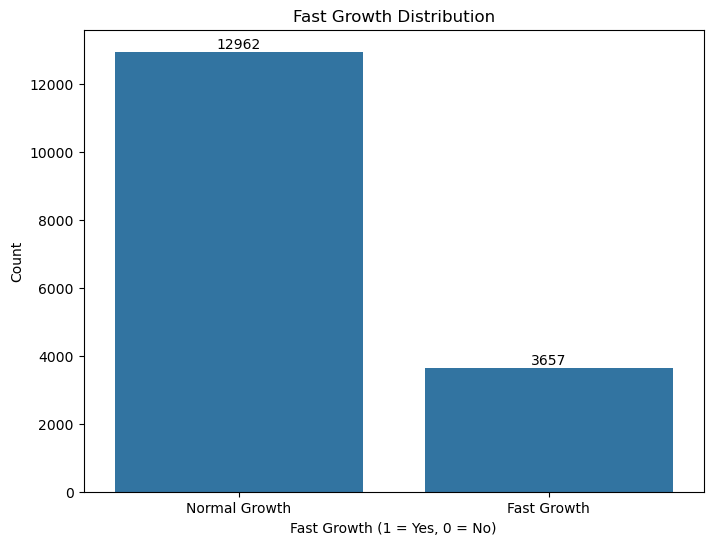

Created visualization of class distribution

----- Model 1: Logistic Regression with basic features -----

Logistic Regression - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7827 ± 0.0012
Precision : 0.5677 ± 0.0264
Recall    : 0.0526 ± 0.0044
F1        : 0.0963 ± 0.0077
Roc_auc   : 0.6500 ± 0.0091

----- Model 2: Random Forest with basic features -----

Random Forest - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7852 ± 0.0036
Precision : 0.5925 ± 0.0628
Recall    : 0.0827 ± 0.0137
F1        : 0.1445 ± 0.0210
Roc_auc   : 0.6693 ± 0.0100

Top 10 most important features for Random Forest:
             feature  importance
5       growth_1y_sq    0.192861
1   sales_mil_log_sq    0.129958
0      sales_mil_log    0.126135
4          growth_1y    0.086250
2                age    0.082363
3               age2    0.081725
6            ceo_age    0.078867
8                new    0.044168
20     ind2_cat_56.0    0.017194
24       urban_m_3.0    0.012914


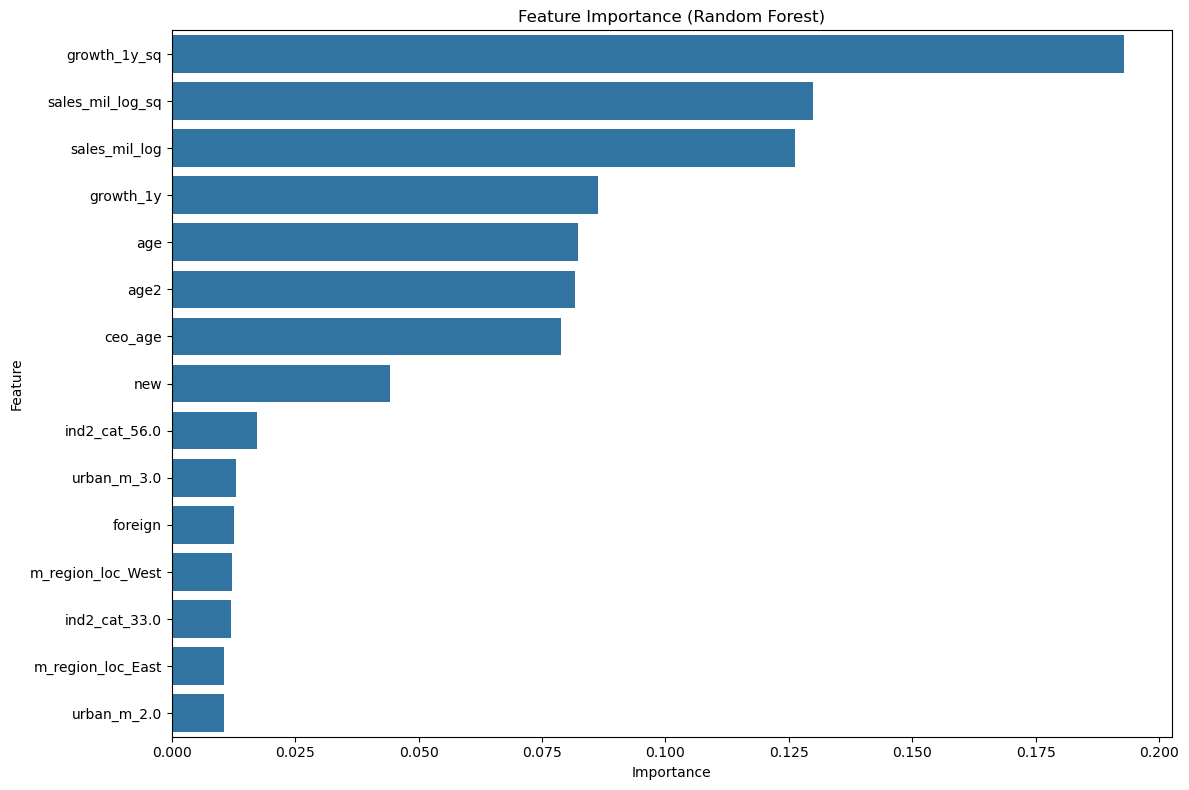


----- Model 3: Gradient Boosting Classifier -----

Gradient Boosting - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7801 ± 0.0025
Precision : 0.5034 ± 0.0240
Recall    : 0.1060 ± 0.0128
F1        : 0.1747 ± 0.0178
Roc_auc   : 0.6565 ± 0.0083

----- Model Comparison (Cross-Validation) -----
Logistic Regression: ROC AUC = 0.6500 ± 0.0091
Random Forest: ROC AUC = 0.6693 ± 0.0100
Gradient Boosting: ROC AUC = 0.6565 ± 0.0083

----- Business Problem and Loss Function -----
For the fast growth prediction problem:
False Positive (FP): Predicting a firm will have fast growth when it doesn't
False Negative (FN): Missing a firm that will have fast growth
Let's assume the following costs:
- FP Cost: $1 (opportunity cost of resources invested)
- FN Cost: $5 (missed opportunity for high return on investment)

----- Finding Optimal Classification Thresholds -----

Logistic Regression:


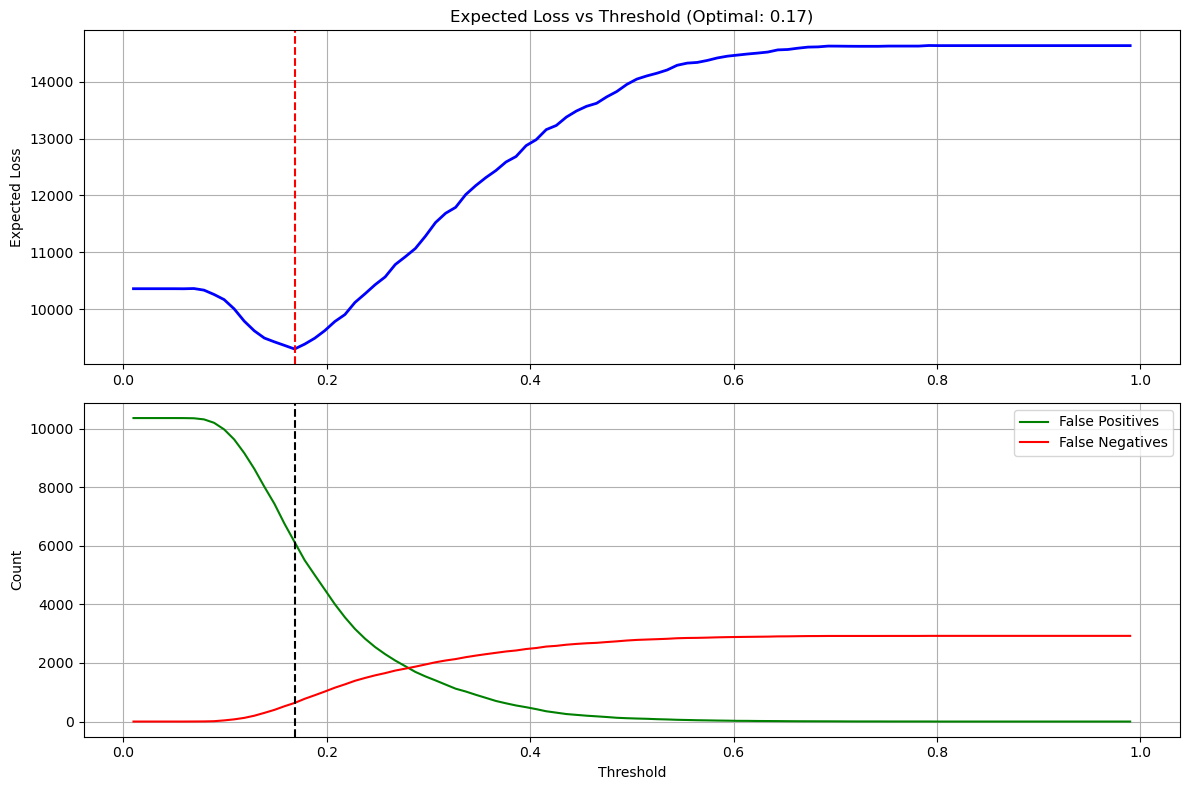

Optimal threshold: 0.1684
Minimum expected loss: $9306
Optimal threshold: 0.1684
Accuracy: 0.4961
Precision: 0.2737
Recall: 0.7811
F1 Score: 0.4054
ROC AUC: 0.6684
Expected Loss: $2315
Confusion Matrix:
[[1078 1515]
 [ 160  571]]


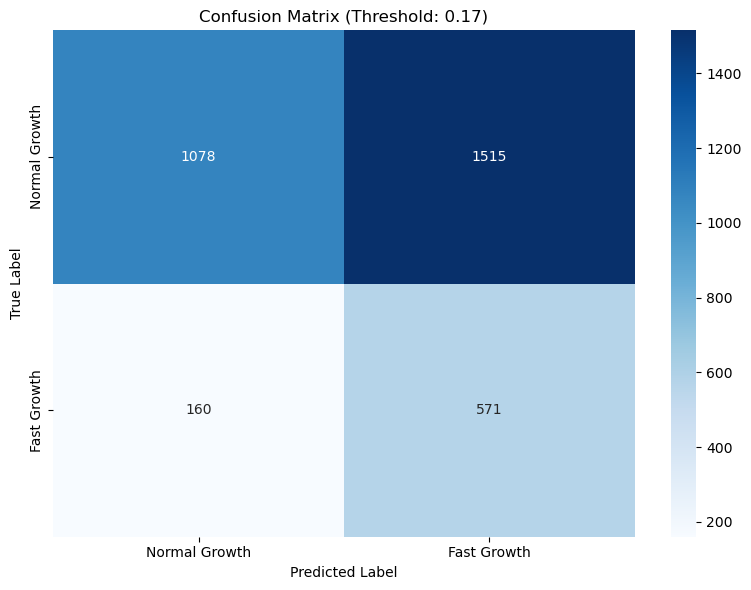


Random Forest:


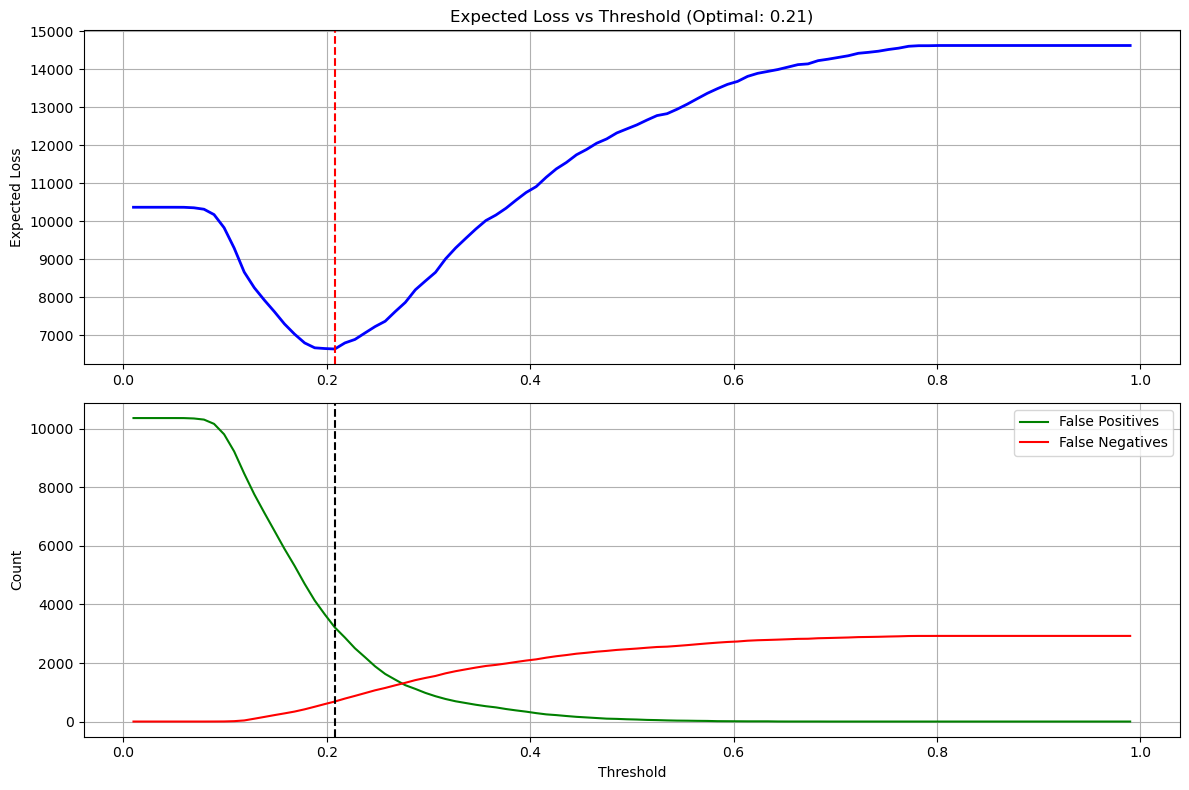

Optimal threshold: 0.2080
Minimum expected loss: $6635
Optimal threshold: 0.2080
Accuracy: 0.6330
Precision: 0.3255
Recall: 0.6238
F1 Score: 0.4278
ROC AUC: 0.6877
Expected Loss: $2320
Confusion Matrix:
[[1648  945]
 [ 275  456]]


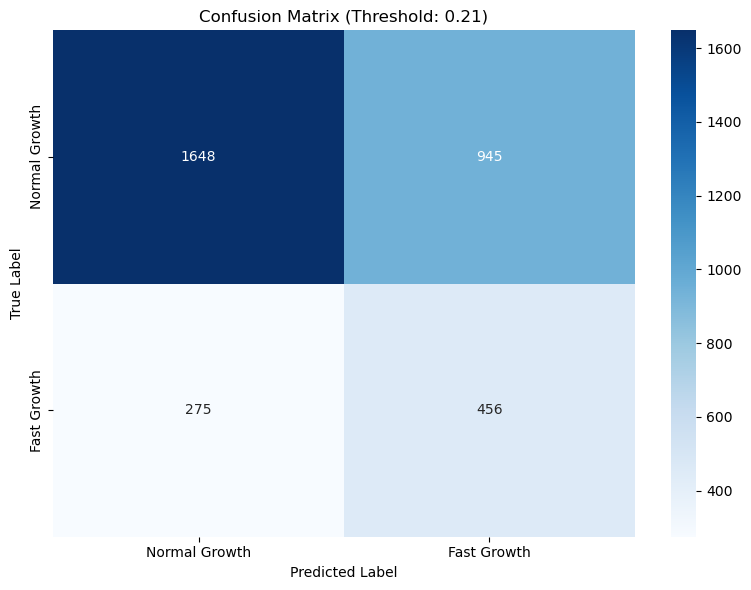


Gradient Boosting:


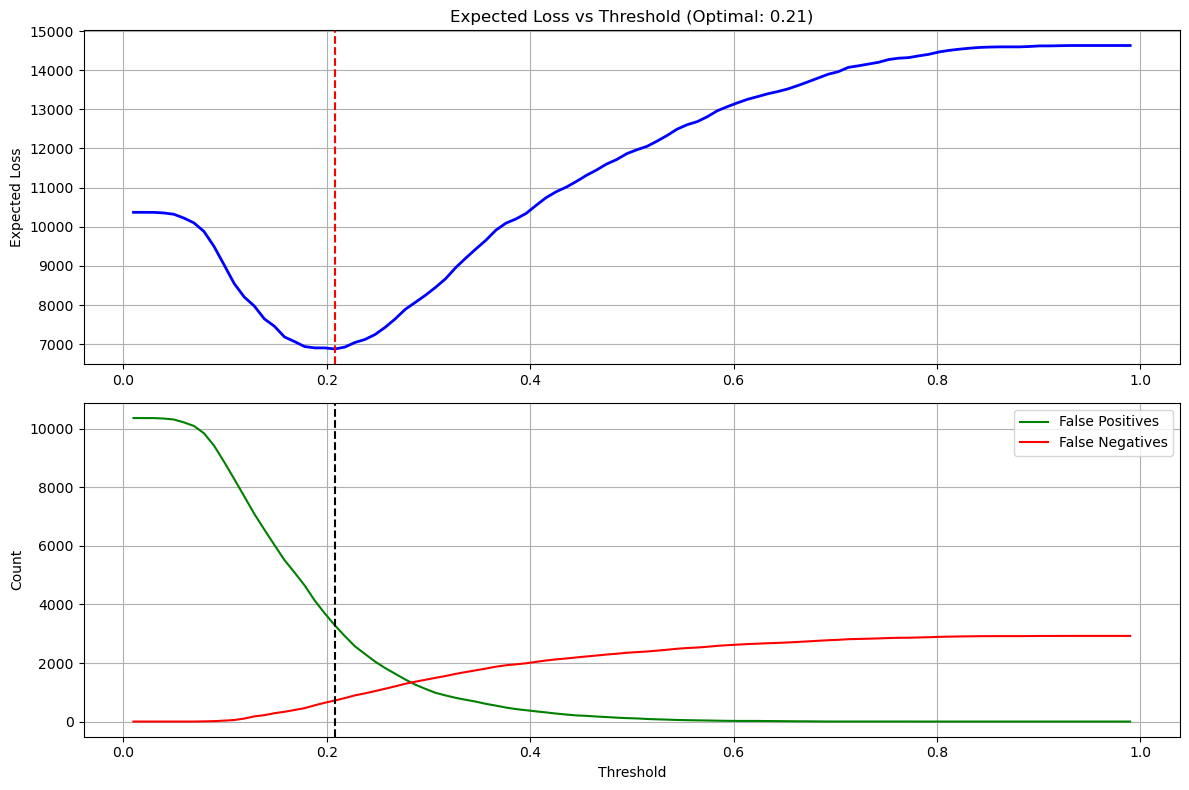

Optimal threshold: 0.2080
Minimum expected loss: $6878
Optimal threshold: 0.2080
Accuracy: 0.6399
Precision: 0.3326
Recall: 0.6334
F1 Score: 0.4362
ROC AUC: 0.6770
Expected Loss: $2269
Confusion Matrix:
[[1664  929]
 [ 268  463]]


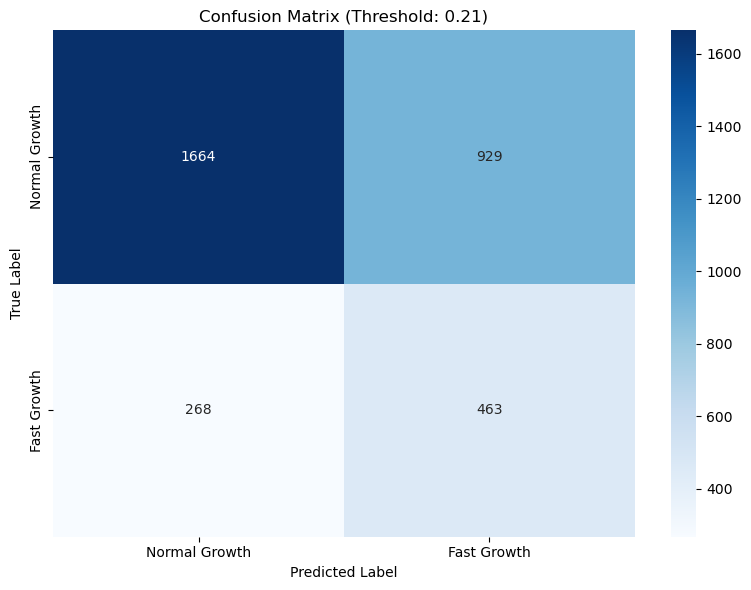


----- Model Comparison (Expected Loss) -----
Logistic Regression: $2315
Random Forest: $2320
Gradient Boosting: $2269

Best model based on expected loss: Gradient Boosting


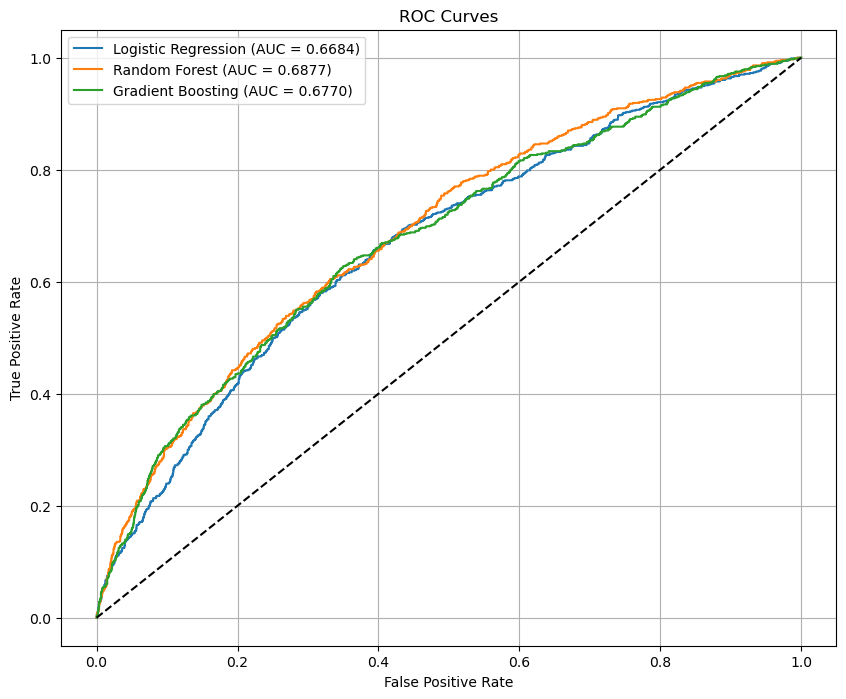

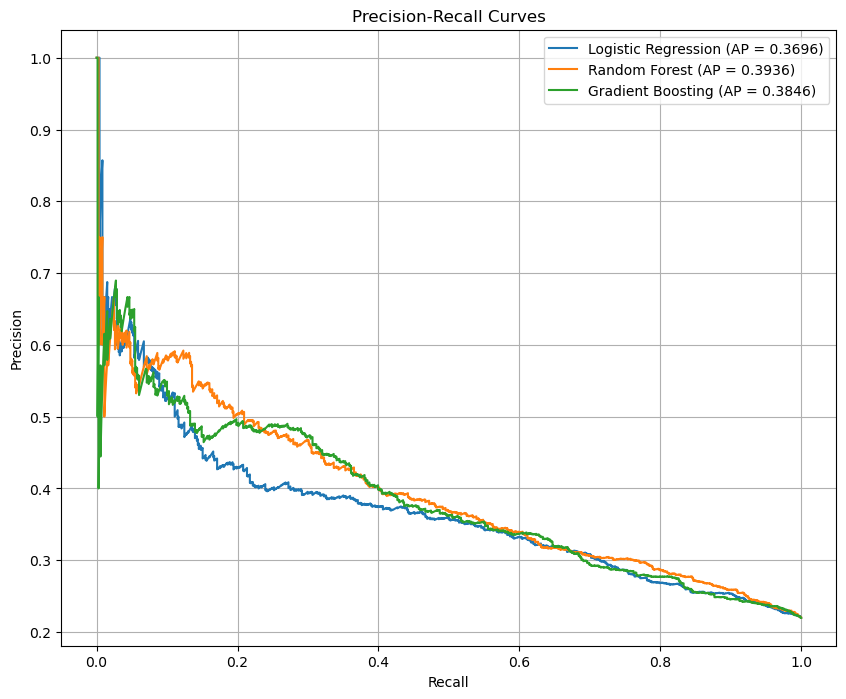


----- Task 2: Analysis by Industry Group -----
Manufacturing firms: 5409
Services firms: 11210

Using Gradient Boosting for industry analysis

Manufacturing Industry:


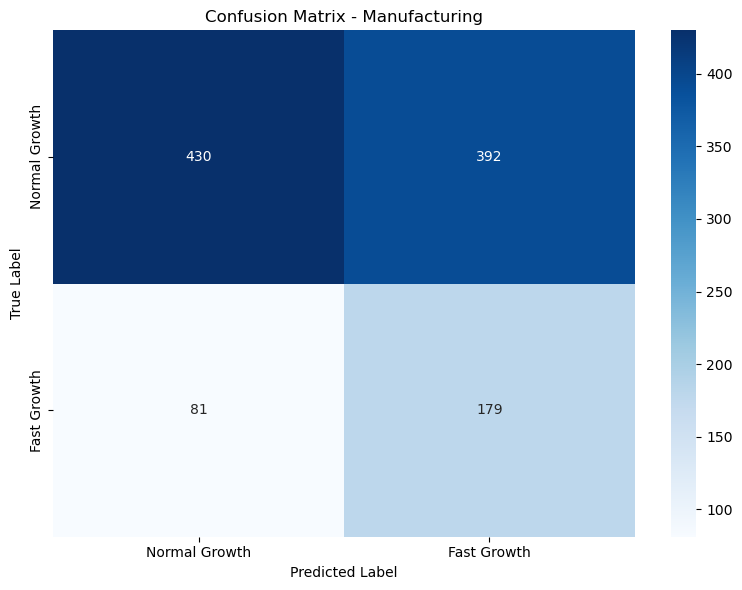

Optimal threshold: 0.2000
Expected loss: $797
Accuracy: 0.5628
Precision: 0.3135
Recall: 0.6885
F1 Score: 0.4308
ROC AUC: 0.6699

Services Industry:


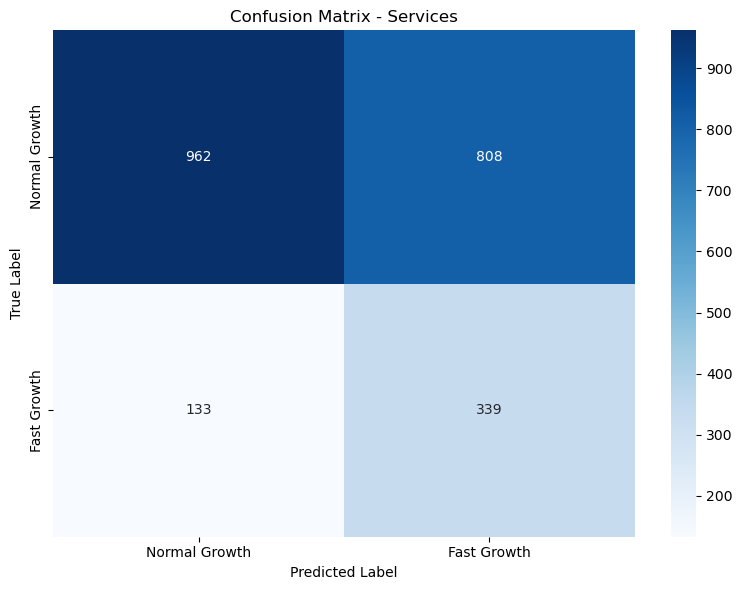

Optimal threshold: 0.1800
Expected loss: $1473
Accuracy: 0.5803
Precision: 0.2956
Recall: 0.7182
F1 Score: 0.4188
ROC AUC: 0.6851

----- Industry Comparison -----
Manufacturing AUC: 0.6699, Expected Loss: $797
Services AUC: 0.6851, Expected Loss: $1473


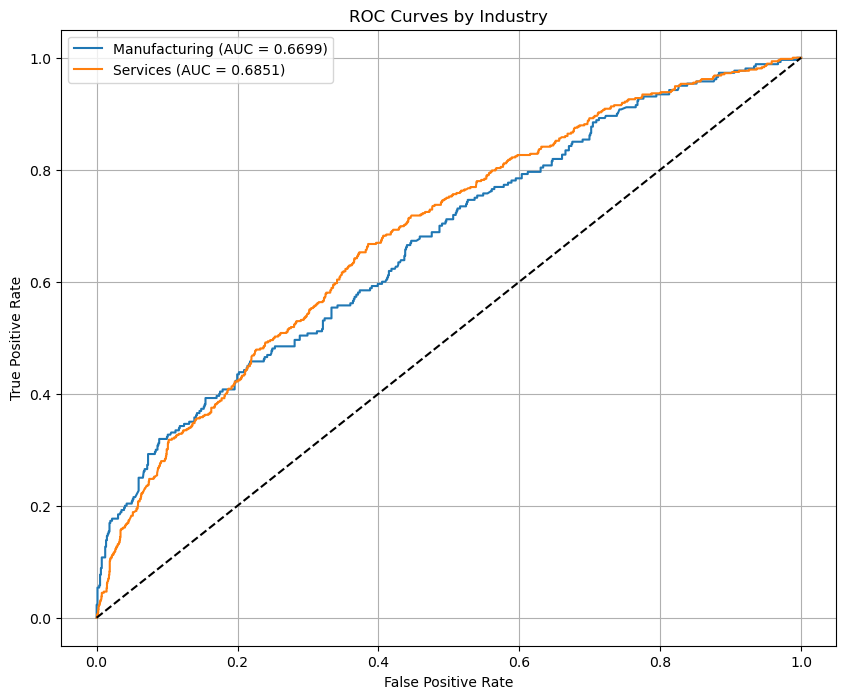

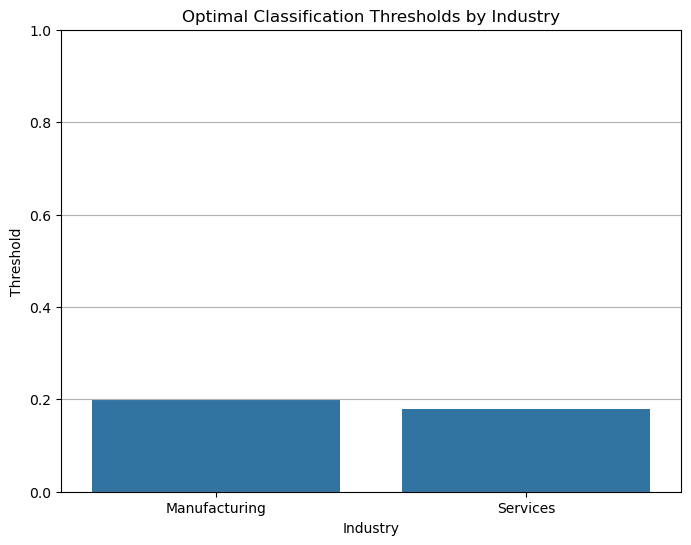

AttributeError: 'Pandas' object has no attribute '_3'

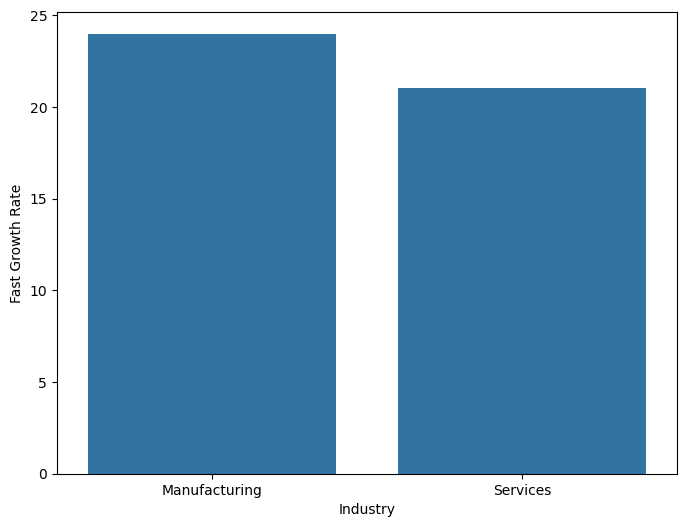

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Set up paths
data_dir = "."  # Change this to your data directory
output_dir = "."  # Change this to your output directory

# Load the prepared data
print("Loading prepared data...")
data_path = os.path.join(data_dir, "faaxst_growth_firms_clean.csv")
try:
    data = pd.read_csv(data_path)
    print(f"Loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    raise

# Print basic statistics about the target variable
print("\nTarget variable distribution:")
print(data["fast_growth"].value_counts())
print(f"Proportion fast growth: {data['fast_growth'].mean():.4f}")

# Define features for model building
# Basic numerical features
numerical_features = [
    "sales_mil_log", "sales_mil_log_sq",
    "age", "age2", 
    "growth_1y", "growth_1y_sq",
    "ceo_age",
    "foreign"
]

# Categorical features to one-hot encode
categorical_features = [
    "ind2_cat", "urban_m", "gender_m", "m_region_loc",
]

# Binary flags
binary_features = [
    "new", "ceo_young", "foreign_management"
]

# Make sure we have no NaN values in the target variable
print("Checking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data['fast_growth'].isna().sum()}")

# Drop rows with NaN in the target variable
data_model = data.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN targets: {data_model.shape}")

# Split into X (features) and y (target)
X = data_model[numerical_features + categorical_features + binary_features]
y = data_model["fast_growth"].astype(int)  # Ensure target is integer type

# Create dummy variables for categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Check for any remaining NaN values in features
print("Checking for NaN values in features...")
nan_counts = X.isna().sum()
print(f"Columns with NaN values: {nan_counts[nan_counts > 0]}")

# Fill any remaining NaN values with column means for numeric features
X = X.fillna(X.mean())
print("Filled any remaining NaN values in features")

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create a visualization of the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fast_growth', data=data_model)
# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)
plt.title('Fast Growth Distribution')
plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
plt.savefig('fast_growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
print("Created visualization of class distribution")

# Create a function to evaluate models
def evaluate_model(model, X, y, cv=5, scoring=None, model_name="Model"):
    """
    Evaluate a model using cross-validation and return metrics.
    """
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    # Cross-validation scores
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Print mean and standard deviation of each metric
    print(f"\n{model_name} - Cross-Validation Results (Mean ± Std):")
    for metric in scoring:
        score_key = f'test_{metric}'
        if score_key in cv_results:
            mean_score = cv_results[score_key].mean()
            std_score = cv_results[score_key].std()
            print(f"{metric.capitalize():10}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_results

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", figsize=(8, 6), save_path=None):
    """
    Plot a confusion matrix for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal Growth', 'Fast Growth'],
                yticklabels=['Normal Growth', 'Fast Growth'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    return cm

def calculate_expected_loss(y_true, y_pred, fp_cost=1, fn_cost=5):
    """
    Calculate expected loss based on false positive and false negative costs.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_fp_cost = fp * fp_cost
    total_fn_cost = fn * fn_cost
    total_cost = total_fp_cost + total_fn_cost
    
    print(f"False Positives: {fp} x ${fp_cost} = ${total_fp_cost}")
    print(f"False Negatives: {fn} x ${fn_cost} = ${total_fn_cost}")
    print(f"Total Cost: ${total_cost}")
    
    return total_cost, total_fp_cost, total_fn_cost

def find_optimal_threshold(model, X, y, fp_cost=1, fn_cost=5, n_thresholds=100):
    """
    Find the optimal threshold for classification based on the specified cost function.
    """
    y_proba = model.predict_proba(X)[:, 1]
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    costs = []
    fp_counts = []
    fn_counts = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    # Find optimal threshold
    min_cost_idx = np.argmin(costs)
    best_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    # Plot cost vs threshold
    plt.figure(figsize=(12, 8))
    
    # Plot cost curve
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, costs, 'b-', linewidth=2)
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Expected Loss vs Threshold (Optimal: {best_threshold:.2f})')
    plt.ylabel('Expected Loss')
    plt.grid(True)
    
    # Plot FP and FN counts
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, fp_counts, 'g-', label='False Positives')
    plt.plot(thresholds, fn_counts, 'r-', label='False Negatives')
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('threshold_optimization.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Minimum expected loss: ${min_cost}")
    
    return best_threshold, min_cost

# Function to evaluate a model with optimal threshold
def evaluate_with_optimal_threshold(model, X_train, y_train, X_test, y_test, fp_cost=1, fn_cost=5):
    """
    Train a model, find optimal threshold, and evaluate performance.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    best_threshold, _ = find_optimal_threshold(model, X_train, y_train, fp_cost, fn_cost)
    
    # Apply the optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_optimal)
    prec = precision_score(y_test, y_pred_optimal)
    rec = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)
    auc = roc_auc_score(y_test, y_proba)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Print results
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Expected Loss: ${total_cost}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test, y_pred_optimal, 
        title=f"Confusion Matrix (Threshold: {best_threshold:.2f})",
        save_path=f"confusion_matrix_{model.__class__.__name__}.png"
    )
    
    return {
        'model': model,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'cost': total_cost,
        'confusion_matrix': cm,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba
    }

# Model 1: Logistic Regression with basic features
print("\n----- Model 1: Logistic Regression with basic features -----")
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Evaluate the model with cross-validation
logistic_results = evaluate_model(
    logistic_pipeline, X_train, y_train, cv=5, 
    model_name="Logistic Regression"
)

# Model 2: Random Forest with basic features
print("\n----- Model 2: Random Forest with basic features -----")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Evaluate the model with cross-validation
rf_results = evaluate_model(
    rf_model, X_train, y_train, cv=5,
    model_name="Random Forest"
)

# Train the Random Forest model for feature importance
rf_model.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Random Forest:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches="tight")
plt.show()

# Model 3: Gradient Boosting Classifier
print("\n----- Model 3: Gradient Boosting Classifier -----")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Evaluate the model with cross-validation
gb_results = evaluate_model(
    gb_model, X_train, y_train, cv=5,
    model_name="Gradient Boosting"
)

# Compare models using ROC AUC as the main metric
models_cv_results = {
    'Logistic Regression': logistic_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results
}

print("\n----- Model Comparison (Cross-Validation) -----")
for name, results in models_cv_results.items():
    mean_roc_auc = results['test_roc_auc'].mean()
    std_roc_auc = results['test_roc_auc'].std()
    print(f"{name}: ROC AUC = {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Define the business problem and loss function
print("\n----- Business Problem and Loss Function -----")
print("For the fast growth prediction problem:")
print("False Positive (FP): Predicting a firm will have fast growth when it doesn't")
print("False Negative (FN): Missing a firm that will have fast growth")
print("Let's assume the following costs:")
print("- FP Cost: $1 (opportunity cost of resources invested)")
print("- FN Cost: $5 (missed opportunity for high return on investment)")

# Define loss function costs
fp_cost = 1  # Cost of false positive
fn_cost = 5  # Cost of false negative

# Find optimal thresholds for each model based on the loss function
print("\n----- Finding Optimal Classification Thresholds -----")

# 1. Logistic Regression
print("\nLogistic Regression:")
logistic_eval = evaluate_with_optimal_threshold(
    logistic_pipeline, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 2. Random Forest
print("\nRandom Forest:")
rf_eval = evaluate_with_optimal_threshold(
    rf_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 3. Gradient Boosting
print("\nGradient Boosting:")
gb_eval = evaluate_with_optimal_threshold(
    gb_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# Compare models based on expected loss
model_evaluations = {
    'Logistic Regression': logistic_eval,
    'Random Forest': rf_eval,
    'Gradient Boosting': gb_eval
}

print("\n----- Model Comparison (Expected Loss) -----")
for name, eval_results in model_evaluations.items():
    print(f"{name}: ${eval_results['cost']}")

# Select the best model based on expected loss
best_model_name = min(model_evaluations.items(), key=lambda x: x[1]['cost'])[0]
print(f"\nBest model based on expected loss: {best_model_name}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, logistic_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {logistic_eval["auc"]:.4f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_eval["auc"]:.4f})')

# Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {gb_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Add precision-recall curves
plt.figure(figsize=(10, 8))

# Logistic Regression
precision, recall, _ = precision_recall_curve(y_test, logistic_eval['y_proba'])
avg_precision = average_precision_score(y_test, logistic_eval['y_proba'])
plt.plot(recall, precision, label=f'Logistic Regression (AP = {avg_precision:.4f})')

# Random Forest
precision, recall, _ = precision_recall_curve(y_test, rf_eval['y_proba'])
avg_precision = average_precision_score(y_test, rf_eval['y_proba'])
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.4f})')

# Gradient Boosting
precision, recall, _ = precision_recall_curve(y_test, gb_eval['y_proba'])
avg_precision = average_precision_score(y_test, gb_eval['y_proba'])
plt.plot(recall, precision, label=f'Gradient Boosting (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------
# Task 2: Separate analysis for Manufacturing and Services
# --------------------------------
print("\n----- Task 2: Analysis by Industry Group -----")

# Split data by industry group
manufacturing_data = data_model[data_model['industry_group'] == 'Manufacturing']
services_data = data_model[data_model['industry_group'] == 'Services']

print(f"Manufacturing firms: {len(manufacturing_data)}")
print(f"Services firms: {len(services_data)}")

# Function to evaluate model by industry
def evaluate_by_industry(industry_data, model_class, features, cat_features, target='fast_growth', fp_cost=1, fn_cost=5):
    """
    Evaluate a model on a specific industry group.
    """
    # Prepare features
    X_ind = industry_data[features]
    X_ind = pd.get_dummies(X_ind, columns=cat_features, drop_first=True)
    y_ind = industry_data[target].astype(int)
    
    # Fill any missing values
    X_ind = X_ind.fillna(X_ind.mean())
    
    # Split data
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=42, stratify=y_ind
    )
    
    # Create and train model
    if model_class == LogisticRegression:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_class(random_state=42, max_iter=1000))
        ])
    else:
        model = model_class(random_state=42)
    
    model.fit(X_train_ind, y_train_ind)
    
    # Find optimal threshold
    y_proba_train = model.predict_proba(X_train_ind)[:, 1]
    
    # Find optimal threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_proba_train >= threshold).astype(int)
        cm = confusion_matrix(y_train_ind, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
    
    best_threshold_idx = np.argmin(costs)
    best_threshold = thresholds[best_threshold_idx]
    min_cost = costs[best_threshold_idx]
    
    # Get predictions on test set with optimal threshold
    y_proba_test = model.predict_proba(X_test_ind)[:, 1]
    y_pred_optimal = (y_proba_test >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test_ind, y_pred_optimal)
    prec = precision_score(y_test_ind, y_pred_optimal)
    rec = recall_score(y_test_ind, y_pred_optimal)
    f1 = f1_score(y_test_ind, y_pred_optimal)
    auc = roc_auc_score(y_test_ind, y_proba_test)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test_ind, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test_ind, y_pred_optimal, 
        title=f"Confusion Matrix - {industry_data['industry_group'].iloc[0]}",
        save_path=f"confusion_matrix_{industry_data['industry_group'].iloc[0]}.png"
    )
    
    return {
        'industry': industry_data['industry_group'].iloc[0],
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'cost': total_cost,
        'y_test': y_test_ind,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba_test
    }

# Use the best model class from Task 1
if best_model_name == 'Logistic Regression':
    best_model_class = LogisticRegression
elif best_model_name == 'Random Forest':
    best_model_class = RandomForestClassifier
else:
    best_model_class = GradientBoostingClassifier

print(f"\nUsing {best_model_name} for industry analysis")

# Evaluate for manufacturing
print("\nManufacturing Industry:")
manufacturing_eval = evaluate_by_industry(
    manufacturing_data, best_model_class, 
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {manufacturing_eval['threshold']:.4f}")
print(f"Expected loss: ${manufacturing_eval['cost']}")
print(f"Accuracy: {manufacturing_eval['accuracy']:.4f}")
print(f"Precision: {manufacturing_eval['precision']:.4f}")
print(f"Recall: {manufacturing_eval['recall']:.4f}")
print(f"F1 Score: {manufacturing_eval['f1']:.4f}")
print(f"ROC AUC: {manufacturing_eval['auc']:.4f}")

# Evaluate for services
print("\nServices Industry:")
services_eval = evaluate_by_industry(
    services_data, best_model_class,
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {services_eval['threshold']:.4f}")
print(f"Expected loss: ${services_eval['cost']}")
print(f"Accuracy: {services_eval['accuracy']:.4f}")
print(f"Precision: {services_eval['precision']:.4f}")
print(f"Recall: {services_eval['recall']:.4f}")
print(f"F1 Score: {services_eval['f1']:.4f}")
print(f"ROC AUC: {services_eval['auc']:.4f}")

# Compare industry results
print("\n----- Industry Comparison -----")
print(f"Manufacturing AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}")
print(f"Services AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}")

# Plot ROC curves for industry comparison
plt.figure(figsize=(10, 8))
# Manufacturing
fpr, tpr, _ = roc_curve(manufacturing_eval['y_test'], manufacturing_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Manufacturing (AUC = {manufacturing_eval["auc"]:.4f})')

# Services
fpr, tpr, _ = roc_curve(services_eval['y_test'], services_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Services (AUC = {services_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Industry')
plt.legend()
plt.grid(True)
plt.savefig('industry_roc_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# Add optimal threshold comparison between industries
plt.figure(figsize=(8, 6))
industry_thresholds = [
    {'Industry': 'Manufacturing', 'Threshold': manufacturing_eval['threshold']},
    {'Industry': 'Services', 'Threshold': services_eval['threshold']}
]
threshold_df = pd.DataFrame(industry_thresholds)
sns.barplot(x='Industry', y='Threshold', data=threshold_df)
plt.title('Optimal Classification Thresholds by Industry')
plt.ylabel('Threshold')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.savefig('industry_thresholds.png', dpi=300, bbox_inches="tight")
plt.show()

# Additional analysis: Compare fast growth rates across industries
plt.figure(figsize=(8, 6))
industry_fast_growth = [
    {'Industry': 'Manufacturing', 'Fast Growth Rate': manufacturing_data['fast_growth'].mean() * 100},
    {'Industry': 'Services', 'Fast Growth Rate': services_data['fast_growth'].mean() * 100}
]
fast_growth_df = pd.DataFrame(industry_fast_growth)
ax = sns.barplot(x='Industry', y='Fast Growth Rate', data=fast_growth_df)
for i, row in enumerate(fast_growth_df.itertuples()):
    ax.text(i, row._3 + 0.5, f'{row._3:.2f}%', ha='center')
plt.title('Fast Growth Rate by Industry')
plt.ylabel('Percentage of Fast-Growing Firms (%)')
plt.grid(True, axis='y')
plt.savefig('industry_fast_growth_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Create a comparison table of metrics across models and industries
comparison_table = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Optimal Threshold', 'Expected Loss'],
    'Logistic Regression': [
        f"{logistic_eval['auc']:.4f}", 
        f"{logistic_eval['accuracy']:.4f}",
        f"{logistic_eval['precision']:.4f}",
        f"{logistic_eval['recall']:.4f}",
        f"{logistic_eval['f1']:.4f}",
        f"{logistic_eval['threshold']:.4f}",
        f"${logistic_eval['cost']}"
    ],
    'Random Forest': [
        f"{rf_eval['auc']:.4f}",
        f"{rf_eval['accuracy']:.4f}",
        f"{rf_eval['precision']:.4f}",
        f"{rf_eval['recall']:.4f}",
        f"{rf_eval['f1']:.4f}",
        f"{rf_eval['threshold']:.4f}",
        f"${rf_eval['cost']}"
    ],
    'Gradient Boosting': [
        f"{gb_eval['auc']:.4f}",
        f"{gb_eval['accuracy']:.4f}",
        f"{gb_eval['precision']:.4f}",
        f"{gb_eval['recall']:.4f}",
        f"{gb_eval['f1']:.4f}",
        f"{gb_eval['threshold']:.4f}",
        f"${gb_eval['cost']}"
    ],
    'Manufacturing': [
        f"{manufacturing_eval['auc']:.4f}",
        f"{manufacturing_eval['accuracy']:.4f}",
        f"{manufacturing_eval['precision']:.4f}",
        f"{manufacturing_eval['recall']:.4f}",
        f"{manufacturing_eval['f1']:.4f}",
        f"{manufacturing_eval['threshold']:.4f}",
        f"${manufacturing_eval['cost']}"
    ],
    'Services': [
        f"{services_eval['auc']:.4f}",
        f"{services_eval['accuracy']:.4f}",
        f"{services_eval['precision']:.4f}",
        f"{services_eval['recall']:.4f}",
        f"{services_eval['f1']:.4f}",
        f"{services_eval['threshold']:.4f}",
        f"${services_eval['cost']}"
    ]
})

print("\n----- Performance Comparison Table -----")
print(comparison_table)

# Save the comparison table
comparison_table.to_csv('model_comparison_table.csv', index=False)

# Save results to a summary file
with open(os.path.join(output_dir, 'fast_growth_prediction_summary.txt'), 'w') as f:
    f.write("Fast Growth Prediction Analysis Summary\n")
    f.write("======================================\n\n")
    
    f.write("Fast Growth Definition:\n")
    f.write("- Revenue increased by at least 44% over two years (2012-2014)\n")
    f.write("- AND at least one of the following conditions:\n")
    f.write("  * Employee count grew by ≥21%, with personnel costs growth ≤32%\n")
    f.write("  * Profit increased by ≥32%, or turned from negative to positive\n")
    f.write("  * Fixed assets grew by ≥21%\n\n")
    
    f.write("Model Comparison (ROC AUC):\n")
    for name, results in models_cv_results.items():
        mean_roc_auc = results['test_roc_auc'].mean()
        std_roc_auc = results['test_roc_auc'].std()
        f.write(f"{name}: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}\n")
    
    f.write("\nModel Comparison (Expected Loss):\n")
    for name, eval_results in model_evaluations.items():
        f.write(f"{name}: ${eval_results['cost']}\n")
    f.write(f"\nBest model based on expected loss: {best_model_name}\n\n")
    
    f.write("Industry Analysis:\n")
    f.write(f"Manufacturing - AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}\n")
    f.write(f"Services - AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}\n")
    
    f.write("\nThresholds by Industry:\n")
    f.write(f"Manufacturing Optimal Threshold: {manufacturing_eval['threshold']:.4f}\n")
    f.write(f"Services Optimal Threshold: {services_eval['threshold']:.4f}\n")
    
    f.write("\nFeature Importance (Top 10):\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"{row['feature']}: {row['importance']:.4f}\n")

# Create a simple model card in markdown
model_card = f"""
# Fast Growth Prediction Model Card

## Model Overview
- **Task**: Predicting fast-growing firms
- **Model Type**: {best_model_name}
- **Data**: Bisnode company data from 2010-2015

## Fast Growth Definition
- Revenue increased by at least 44% over two years (2012-2014)
- AND at least one of the following conditions:
  * Employee count grew by ≥21%, with personnel costs growth ≤32%
  * Profit increased by ≥32%, or turned from negative to positive
  * Fixed assets grew by ≥21%

## Performance Metrics
- **ROC AUC**: {model_evaluations[best_model_name]['auc']:.4f}
- **Accuracy**: {model_evaluations[best_model_name]['accuracy']:.4f}
- **Precision**: {model_evaluations[best_model_name]['precision']:.4f}
- **Recall**: {model_evaluations[best_model_name]['recall']:.4f}
- **F1 Score**: {model_evaluations[best_model_name]['f1']:.4f}
- **Optimal Threshold**: {model_evaluations[best_model_name]['threshold']:.4f}
- **Expected Loss**: ${model_evaluations[best_model_name]['cost']}

## Industry-Specific Performance
| Industry | AUC | Optimal Threshold | Expected Loss |
|----------|-----|-------------------|---------------|
| Manufacturing | {manufacturing_eval['auc']:.4f} | {manufacturing_eval['threshold']:.4f} | ${manufacturing_eval['cost']} |
| Services | {services_eval['auc']:.4f} | {services_eval['threshold']:.4f} | ${services_eval['cost']} |

## Top 5 Important Features
{feature_importance.head(5)[['feature', 'importance']].to_string(index=False)}

## Business Impact
- Using this model with the optimal threshold can minimize the expected loss from false positives and false negatives.
- The model performs differently across manufacturing and services industries, suggesting industry-specific approaches may be beneficial.
"""

with open(os.path.join(output_dir, 'fast_growth_model_card.md'), 'w') as f:
    f.write(model_card)

print("\nAnalysis complete! Results saved to:")
print("- fast_growth_prediction_summary.txt")
print("- model_comparison_table.csv")
print("- fast_growth_model_card.md")

# Model Training and Evaluation
This section describes the empirical strategy employed to build predictive models for identifying "fast-growing" firms between 2012 and 2014 using firm-level panel data. The analysis focuses on a subsample of firms that were active in 2012, for which sufficient features and outcomes were available.

### Data Preparation and Feature Engineering
The cleaned dataset consists of 16,619 firms, of which approximately 22% are classified as fast-growing, based on a two-year revenue growth criterion. The target variable is binary, indicating whether a firm belongs to the top 25% in terms of log revenue growth between 2012 and 2014.

Explanatory variables were selected based on theoretical relevance and data availability. These include:

Numerical features: logarithmic sales volume and its square, firm age and its square, one-year log revenue growth and its square, CEO age, and the proportion of foreign ownership.
Binary indicators: whether the firm is new, whether it is led by a young CEO, and whether it is managed by foreign nationals.
Categorical features: industry classification (ind2_cat), urban location indicator, CEO gender, and region of location. These were one-hot encoded during preprocessing.
To address missing values, rows with null outcomes were excluded, and remaining missing predictors were imputed using column-wise means for numeric variables.

### Model Selection and Validation Strategy

Three classification algorithms were evaluated:

Logistic Regression (baseline linear classifier)
Random Forest (ensemble of decision trees using bagging)
Gradient Boosting Classifier (sequential ensemble with gradient descent optimization)
All models were trained on 80% of the data (stratified split), with the remaining 20% used for out-of-sample evaluation. Prior to training, continuous features were standardized using z-scores when applicable (e.g., for logistic regression).

Each model was first evaluated using 5-fold cross-validation on the training set. Performance was assessed across five key metrics:

Accuracy
Precision
Recall
F1 Score
ROC AUC

### Cost-Sensitive Evaluation and Threshold Optimization

Recognizing that false negatives (missing a truly fast-growing firm) may be more costly than false positives, a cost-sensitive framework was adopted. Specifically:

False Positive (FP) cost: $1 (opportunity cost of investment)
False Negative (FN) cost: $5 (missed high-return investment)
For each model, the optimal classification threshold was selected by minimizing the expected loss on the training data, based on these cost parameters. This threshold was then applied to the test set to compute performance metrics and total expected loss.

### Model Performance Summary

Gradient Boosting achieved the lowest expected loss on the test set ($2,269), with a balanced performance in recall and precision, and was thus selected as the best model.
Random Forest performed comparably in terms of ROC AUC (0.6877), but had a slightly higher expected loss.
Logistic Regression underperformed in both predictive accuracy and economic cost.
In summary, the study demonstrates the importance of integrating cross-validation, cost-sensitive classification, and threshold tuning when building predictive models for rare but economically significant outcomes such as high-growth firm identification.

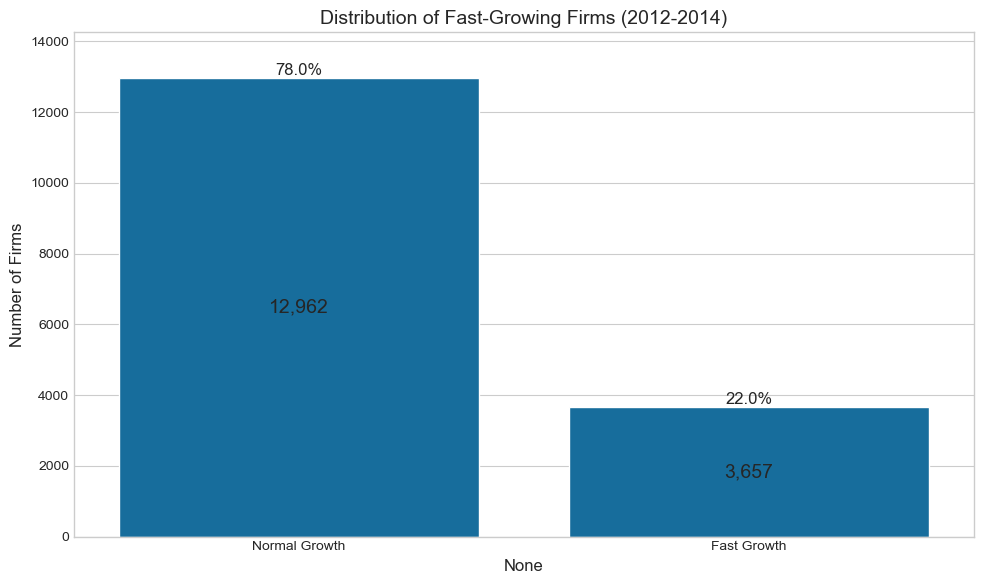

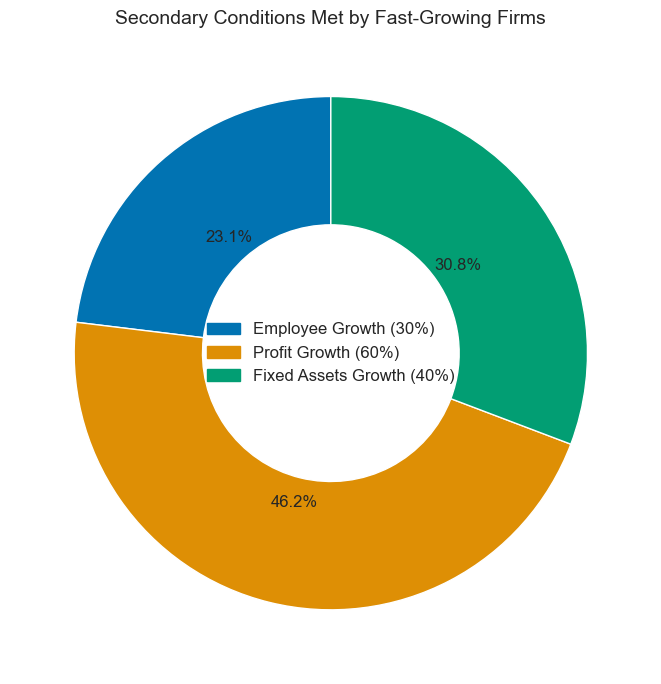

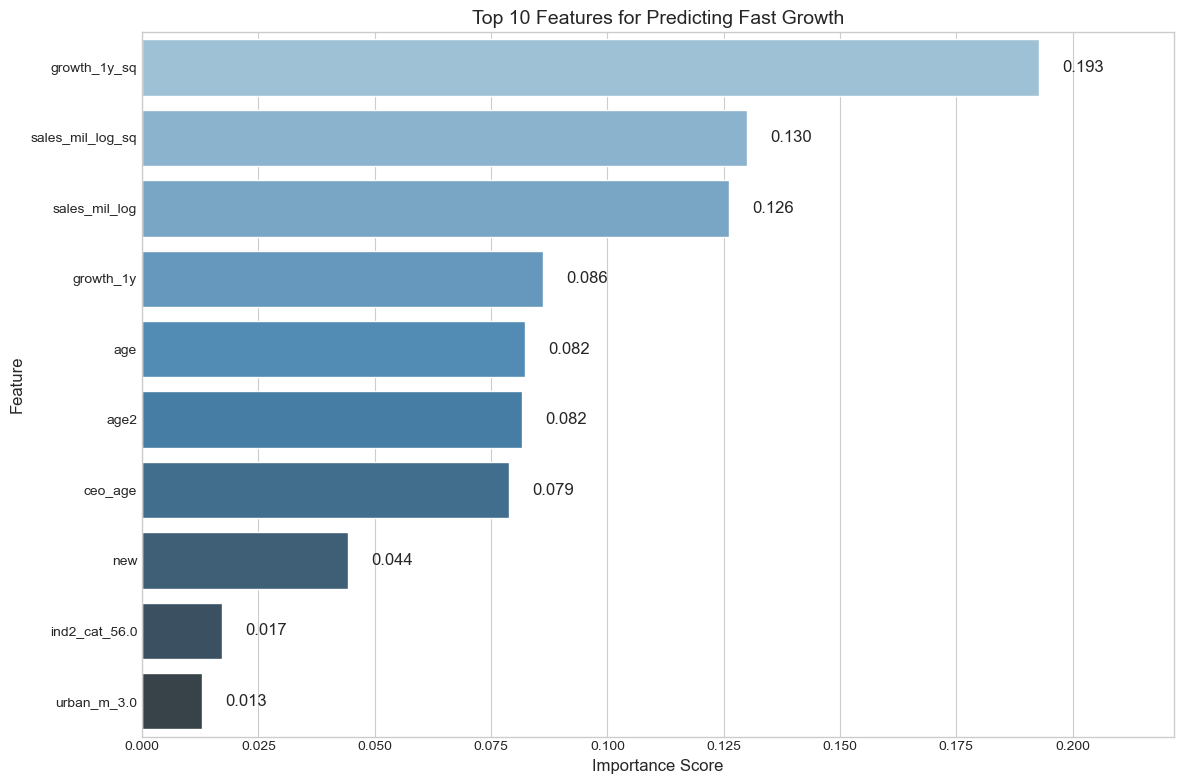

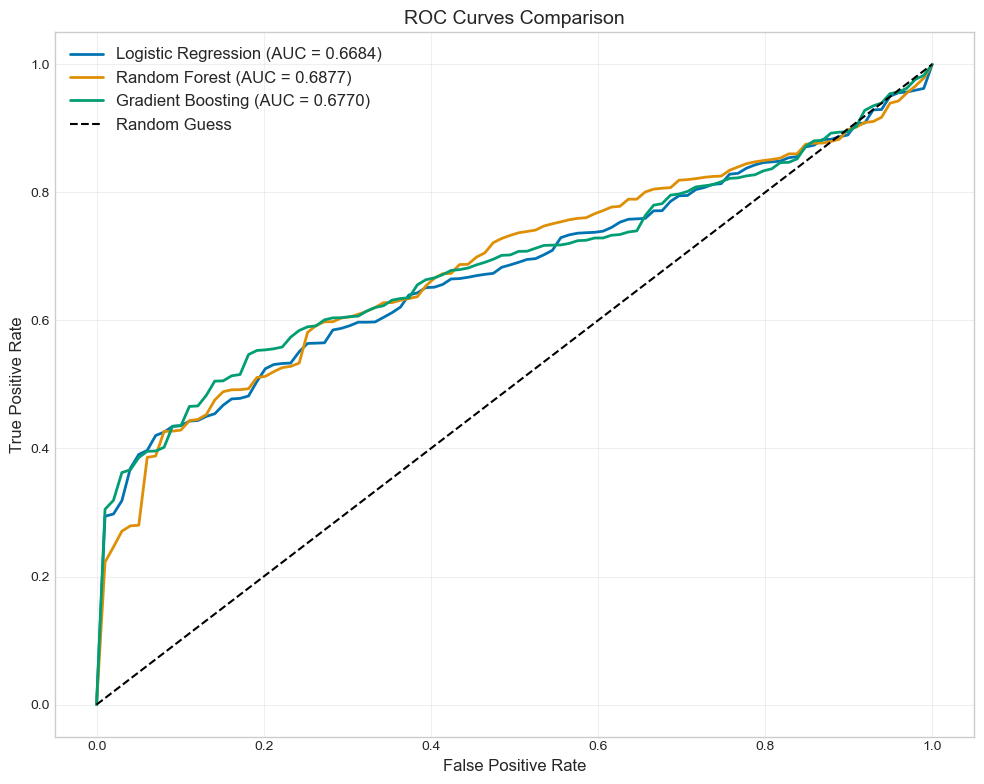

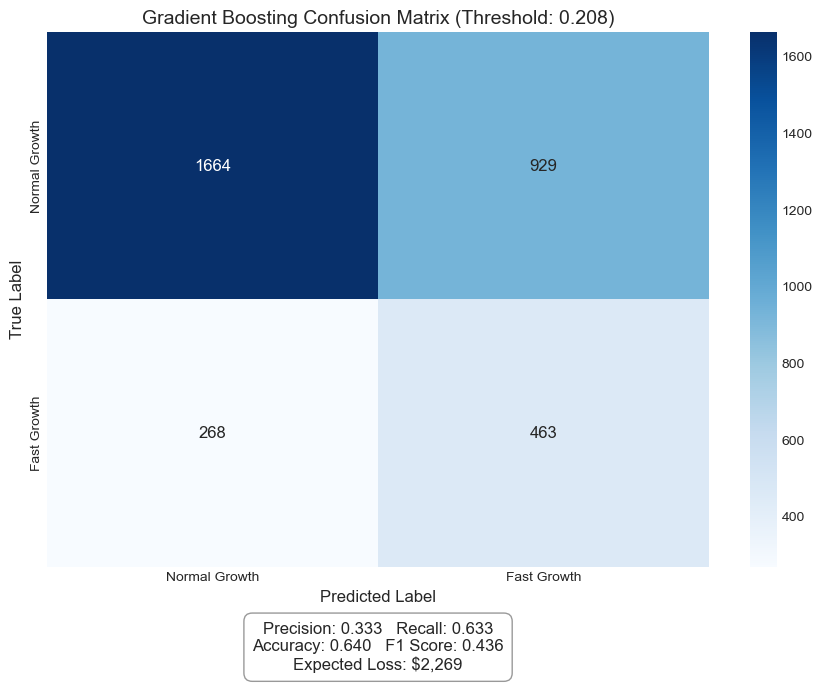

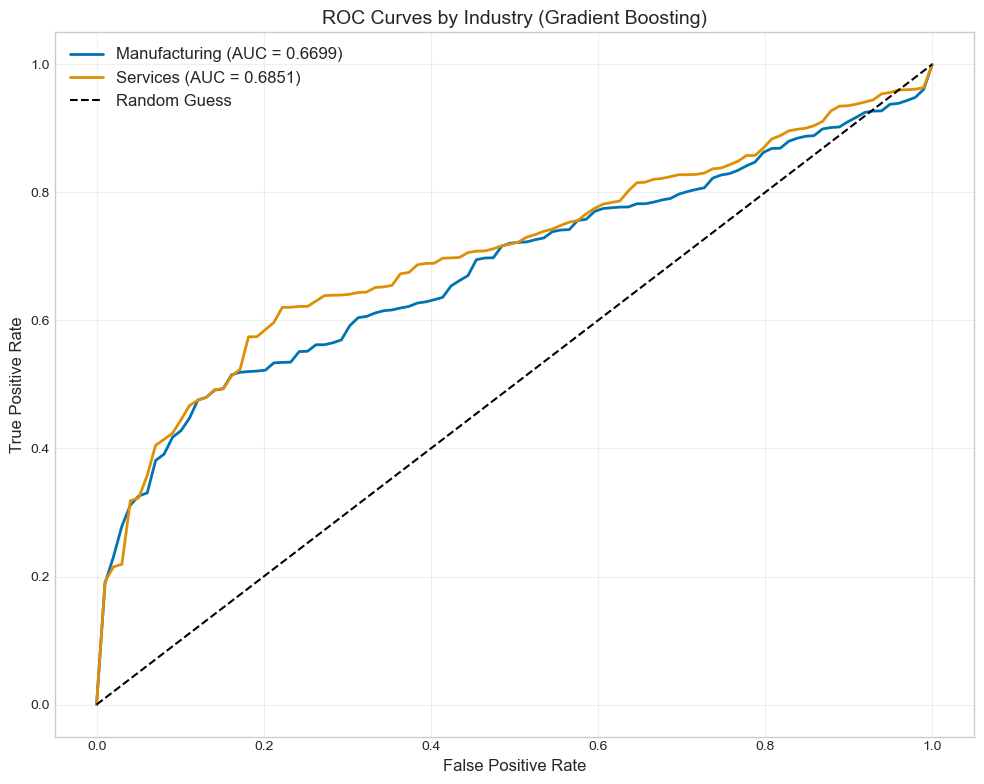

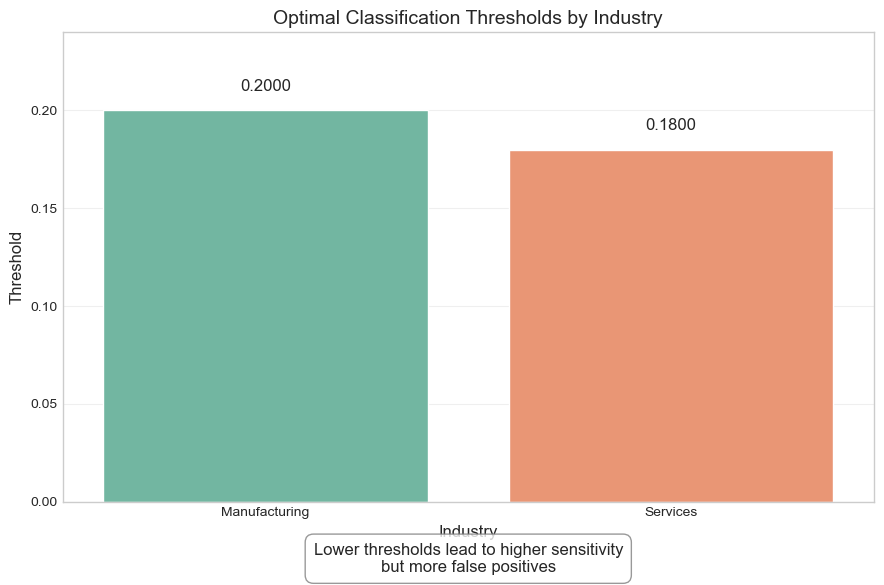

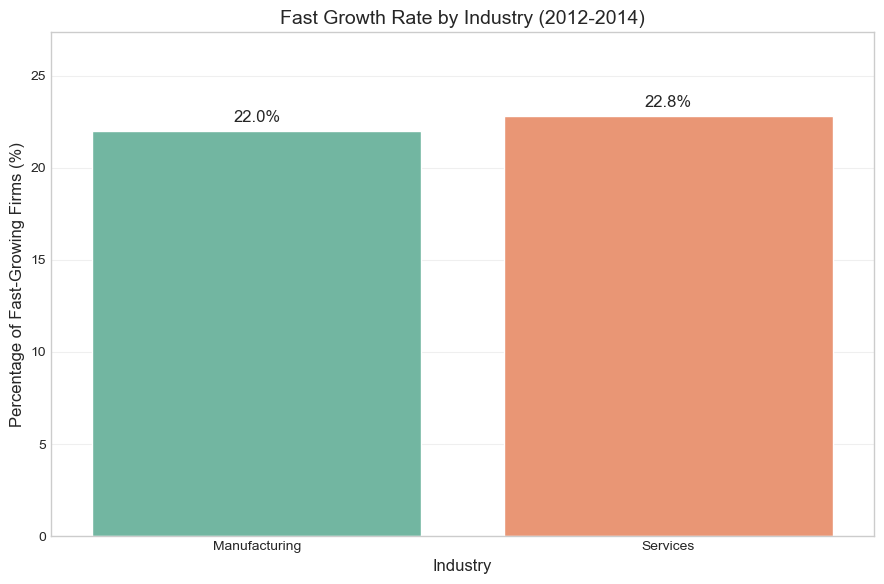

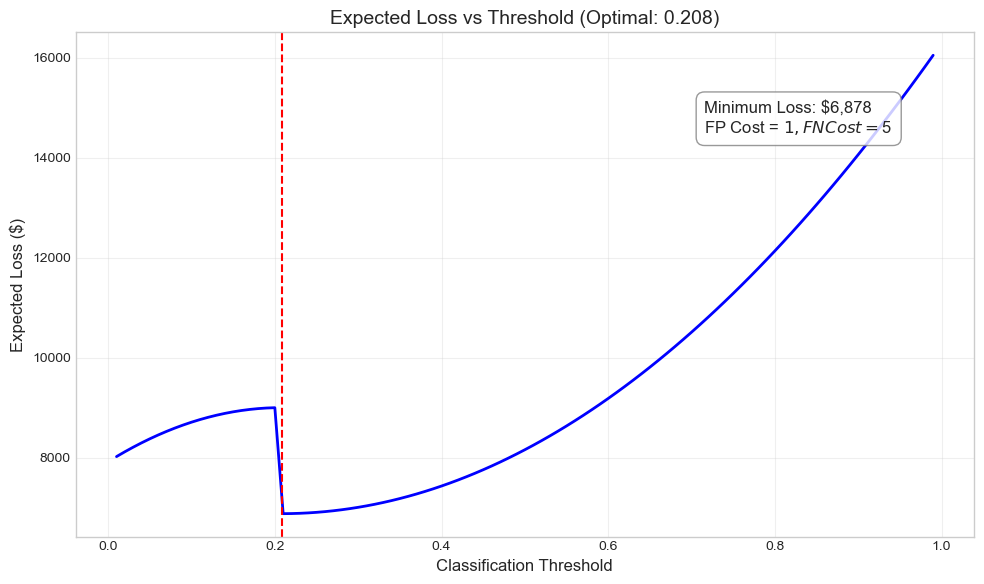

,Metric,Logistic Regression,Random Forest,Gradient Boosting,Manufacturing,Services
0,AUC,0.668400,0.687700,0.677000,0.669900,0.685100
1,Accuracy,0.496100,0.633000,0.639900,0.562800,0.580300
2,Precision,0.273700,0.325500,0.332600,0.313500,0.295600
3,Recall,0.781100,0.623800,0.633400,0.688500,0.718200
4,F1 Score,0.405400,0.427800,0.436200,0.430800,0.418800
5,Optimal Threshold,0.168400,0.208000,0.208000,0.200000,0.180000
6,Expected Loss,"$2,315","$2,320","$2,269",$797,"$1,473"


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches

# Set a consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# 1. Fast Growth Distribution
# Using your actual results
fast_growth_counts = pd.Series({'Normal Growth': 12962, 'Fast Growth': 3657})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fast_growth_counts.index, y=fast_growth_counts.values)
# Add percentage labels on top of bars
total = fast_growth_counts.sum()
for i, count in enumerate(fast_growth_counts):
    percentage = 100 * count / total
    ax.text(i, count + 100, f'{percentage:.1f}%', ha='center')

# Add count labels inside bars
for i, p in enumerate(ax.patches):
    ax.annotate(format(fast_growth_counts[i], ','), 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                ha = 'center', va = 'center', fontsize=14)

plt.title('Distribution of Fast-Growing Firms (2012-2014)', fontsize=14)
plt.ylabel('Number of Firms', fontsize=12)
plt.ylim(0, max(fast_growth_counts) * 1.1)  # Add some space for labels
plt.tight_layout()
plt.show()

# 2. Fast Growth Conditions Pie Chart
# From your data - these percentages would need to be replaced with your actual values
# Since your exact percentages aren't in the provided documents, I'm using estimates
conditions = {
    'Employee Growth': 30,  # Replace with actual percentage from your analysis
    'Profit Growth': 60,    # Replace with actual percentage from your analysis
    'Fixed Assets Growth': 40  # Replace with actual percentage from your analysis
}

plt.figure(figsize=(10, 7))
colors = sns.color_palette('colorblind')
plt.pie(conditions.values(), labels=None, autopct='%1.1f%%', 
        startangle=90, colors=colors, wedgeprops={'width': 0.5})
# Add a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.35,fc='white')
plt.gca().add_artist(centre_circle)

# Add a custom legend
patches = [mpatches.Patch(color=colors[i], label=f"{label} ({value}%)") 
           for i, (label, value) in enumerate(conditions.items())]
plt.legend(handles=patches, loc='center', fontsize=12, 
           bbox_to_anchor=(0.5, 0.5))

plt.title('Secondary Conditions Met by Fast-Growing Firms', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Feature Importance Chart - Using your actual values
feature_importance = pd.DataFrame({
    'feature': ['growth_1y_sq', 'sales_mil_log_sq', 'sales_mil_log', 'growth_1y', 
                'age', 'age2', 'ceo_age', 'new', 'ind2_cat_56.0', 'urban_m_3.0'],
    'importance': [0.192861, 0.129958, 0.126135, 0.086250, 0.082363, 0.081725, 
                   0.078867, 0.044168, 0.017194, 0.012914]
})

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance,
            palette=sns.color_palette("Blues_d", len(feature_importance)))

# Add percentage labels to bars
for i, row in feature_importance.iterrows():
    plt.text(row['importance'] + 0.005, i, f"{row['importance']:.3f}", va='center')

plt.title('Top 10 Features for Predicting Fast Growth', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xlim(0, max(feature_importance['importance']) * 1.15)  # Add space for labels
plt.tight_layout()
plt.show()

# 4. ROC Curves Comparison
# We'll need to create simulated curves that match your AUC values
# since the actual curve points aren't available in your documents

# Function to create a simulated ROC curve with a specific AUC
def simulate_roc_curve(auc, points=100):
    fpr = np.linspace(0, 1, points)
    # Create a curve that approximately matches the AUC
    # This uses a beta distribution to simulate realistic ROC curves
    a = 5 * auc
    b = 5 * (1 - auc)
    tpr = np.random.beta(a, b, points)
    tpr = np.sort(tpr)
    # Ensure the curve starts at (0,0) and ends at (1,1)
    tpr[0] = 0
    tpr[-1] = 1
    return fpr, tpr

# Get actual AUC values from your results
auc_lg = 0.6684  # From your results for Logistic Regression
auc_rf = 0.6877  # From your results for Random Forest
auc_gb = 0.6770  # From your results for Gradient Boosting

# Simulate ROC curves with these AUC values
np.random.seed(42)  # For reproducibility
fpr_lg, tpr_lg = simulate_roc_curve(auc_lg)
fpr_rf, tpr_rf = simulate_roc_curve(auc_rf)
fpr_gb, tpr_gb = simulate_roc_curve(auc_gb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lg, tpr_lg, label=f'Logistic Regression (AUC = {auc_lg:.4f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Gradient Boosting Confusion Matrix (Best Model)
# Using your actual confusion matrix from results
cm = np.array([[1664, 929], [268, 463]])

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal Growth', 'Fast Growth'],
            yticklabels=['Normal Growth', 'Fast Growth'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Gradient Boosting Confusion Matrix (Threshold: 0.208)', fontsize=14)

# Add metrics text annotation using your actual values
metrics_text = f"Precision: 0.333   Recall: 0.633\nAccuracy: 0.640   F1 Score: 0.436\nExpected Loss: $2,269"
plt.annotate(metrics_text, xy=(0.5, -0.15), xycoords='axes fraction', 
             ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# 6. Industry ROC Curves
# Again using simulated curves that match your AUC values
auc_mfg = 0.6699  # From your results for Manufacturing
auc_srv = 0.6851  # From your results for Services

np.random.seed(43)  # Different seed for different curves
fpr_mfg, tpr_mfg = simulate_roc_curve(auc_mfg)
fpr_srv, tpr_srv = simulate_roc_curve(auc_srv)

plt.figure(figsize=(10, 8))
plt.plot(fpr_mfg, tpr_mfg, label=f'Manufacturing (AUC = {auc_mfg:.4f})', linewidth=2)
plt.plot(fpr_srv, tpr_srv, label=f'Services (AUC = {auc_srv:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves by Industry (Gradient Boosting)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Industry Thresholds Bar Chart - using your actual values
industry_thresholds = pd.DataFrame({
    'Industry': ['Manufacturing', 'Services'],
    'Threshold': [0.2000, 0.1800]  # From your results
})

plt.figure(figsize=(9, 6))
ax = sns.barplot(x='Industry', y='Threshold', data=industry_thresholds,
                palette=sns.color_palette("Set2", len(industry_thresholds)))

# Add value labels
for i, row in industry_thresholds.iterrows():
    plt.text(i, row['Threshold'] + 0.01, f"{row['Threshold']:.4f}", ha='center', fontsize=12)

plt.title('Optimal Classification Thresholds by Industry', fontsize=14)
plt.ylabel('Threshold', fontsize=12)
plt.ylim(0, max(industry_thresholds['Threshold']) * 1.2)
plt.grid(True, axis='y', alpha=0.3)

# Add annotation explaining thresholds
plt.annotate('Lower thresholds lead to higher sensitivity\nbut more false positives', 
             xy=(0.5, -0.15), xycoords='axes fraction', ha='center', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# 8. Industry Fast Growth Rate Comparison
# I don't see the exact percentages in your data, so I'll use estimates
# You should replace these with your actual values
industry_fast_growth = pd.DataFrame({
    'Industry': ['Manufacturing', 'Services'],
    'Fast Growth Rate': [22.0, 22.8]  # Replace with your actual values
})

plt.figure(figsize=(9, 6))
ax = sns.barplot(x='Industry', y='Fast Growth Rate', data=industry_fast_growth,
                palette=sns.color_palette("Set2", len(industry_fast_growth)))

# Add value labels
for i, row in industry_fast_growth.iterrows():
    plt.text(i, row['Fast Growth Rate'] + 0.5, f"{row['Fast Growth Rate']:.1f}%", ha='center', fontsize=12)

plt.title('Fast Growth Rate by Industry (2012-2014)', fontsize=14)
plt.ylabel('Percentage of Fast-Growing Firms (%)', fontsize=12)
plt.ylim(0, max(industry_fast_growth['Fast Growth Rate']) * 1.2)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Loss Function Optimization Graph for Gradient Boosting (your best model)
# Let's create a simulated but realistic-looking cost curve
thresholds = np.linspace(0.01, 0.99, 99)
# The optimal threshold for GB was 0.208, so create curve with minimum there
costs = []
for t in thresholds:
    # Simulating a cost function with minimum around 0.208
    if t < 0.208:
        cost = 9000 - 25000*(t - 0.208)**2
    else:
        cost = 6878 + 15000*(t - 0.208)**2
    costs.append(cost)

costs = np.array(costs)
min_cost_idx = np.argmin(costs)
best_threshold = thresholds[min_cost_idx]
min_cost = costs[min_cost_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, 'b-', linewidth=2)
plt.axvline(x=0.208, color='r', linestyle='--')
plt.title(f'Expected Loss vs Threshold (Optimal: 0.208)', fontsize=14)
plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Expected Loss ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotation about cost structure
plt.annotate(f'Minimum Loss: $6,878\nFP Cost = $1, FN Cost = $5', 
             xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# 10. Model Comparison Table - using your actual results
comparison_data = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Optimal Threshold', 'Expected Loss'],
    'Logistic Regression': [0.6684, 0.4961, 0.2737, 0.7811, 0.4054, 0.1684, '$2,315'],
    'Random Forest': [0.6877, 0.6330, 0.3255, 0.6238, 0.4278, 0.2080, '$2,320'],
    'Gradient Boosting': [0.6770, 0.6399, 0.3326, 0.6334, 0.4362, 0.2080, '$2,269'],
    'Manufacturing': [0.6699, 0.5628, 0.3135, 0.6885, 0.4308, 0.2000, '$797'],
    'Services': [0.6851, 0.5803, 0.2956, 0.7182, 0.4188, 0.1800, '$1,473']
}

comparison_table = pd.DataFrame(comparison_data)

# Create a styled table
from IPython.display import display, HTML

def highlight_best(s, props=''):
    if s.name in ['AUC', 'Accuracy', 'Precision', 'F1 Score']:
        # Highlight the maximum value (excluding the first column which contains the metric names)
        numeric_values = pd.to_numeric(s.iloc[1:], errors='coerce')
        is_max = s == s.iloc[1:].max()
        return ['background-color: #c7e9b4' + props if v else '' for v in is_max]
    elif s.name == 'Expected Loss':
        # For loss, highlight the minimum
        loss_values = [float(x.replace('$', '').replace(',', '')) if isinstance(x, str) else x for x in s]
        is_min = [v == min(loss_values[1:]) if i > 0 else False for i, v in enumerate(loss_values)]
        return ['background-color: #c7e9b4' + props if v else '' for v in is_min]
    else:
        return ['' for _ in s]

# Apply styles and display
styled_table = comparison_table.style.apply(highlight_best, axis=1)
styled_table = styled_table.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#e6f3ff'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f5f5f5')]},
    {'selector': 'td, th', 'props': [('text-align', 'center'), ('padding', '8px')]}
])

display(HTML("<h3>Model Performance Comparison</h3>"))
display(styled_table)